<a href="https://colab.research.google.com/github/Danielvimot/Analise-SRG-Cardiopatia/blob/main/analise_sivep_cardiopatia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://docs.google.com/document/d/1J475Co40xFerLyUmyQaMBde2jUKAvt6NY6lEDJ6V83M/edit?usp=drive_link

# Projeto de Análise de Dados SRAG - Entrega 1

## 1. Descrição do Subproblema e da Equipe

**Equipe:**
* Gustavo Santos Novais
* Daniel Viana Mota
* Lafaete Dias Alves

**Subproblema:**
Análise da Cardiopatia Crônica como fator de risco para a gravidade do desfecho (internação em UTI ou Óbito) em pacientes com SRAG.

**Objetivo:**
Quantificar a associação entre a Cardiopatia Crônica e um desfecho grave (definido como internação em UTI **ou** Óbito), controlando por fatores demográficos (idade, sexo) e pelo agente etiológico (ex: COVID-19 vs. Influenza).    *Devido a pandemia o agente etiológico se compreende quase que exclusivamente o covid19, tendo poucos casos identificados como influenza.

**Fonte de Dados:**
SIVEP-Gripe (Sistema de Informação da Vigilância Epidemiológica da Gripe)
* **Período:** 2019-2021 (Baseado nos arquivos carregados)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#csv´s baixados no coolab
!pip install gdown -q
import gdown

# IDs INDIVIDUAIS - um por vez
id_2019 = '1B9rVSkEhmOU84FNMawjCqL8UsRFoIrnX'
id_2020 = '16CrBdKGg0dt99wOF8YzodV6T1Dy2HP4h'
id_2021 = '1X3C5H7e-Maj79qSqgXWTu0UDu69epv3o'

# Baixa CADA arquivo SEPARADAMENTE
gdown.download(f'https://drive.google.com/uc?id={id_2019}', 'INFLUD19-26-06-2025.csv')
gdown.download(f'https://drive.google.com/uc?id={id_2020}', 'INFLUD20-26-06-2025.csv')
gdown.download(f'https://drive.google.com/uc?id={id_2021}', 'INFLUD21-26-06-2025.csv')

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_

Downloading...
From: https://drive.google.com/uc?id=1B9rVSkEhmOU84FNMawjCqL8UsRFoIrnX
To: /content/INFLUD19-26-06-2025.csv
100%|██████████| 44.4M/44.4M [00:00<00:00, 58.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=16CrBdKGg0dt99wOF8YzodV6T1Dy2HP4h
From (redirected): https://drive.google.com/uc?id=16CrBdKGg0dt99wOF8YzodV6T1Dy2HP4h&confirm=t&uuid=79983c38-0813-4d3a-950d-683e6713f450
To: /content/INFLUD20-26-06-2025.csv
100%|██████████| 1.09G/1.09G [00:17<00:00, 62.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1X3C5H7e-Maj79qSqgXWTu0UDu69epv3o
From (redirected): https://drive.google.com/uc?id=1X3C5H7e-Maj79qSqgXWTu0UDu69epv3o&confirm=t&uuid=92292e8d-0521-42de-bae7-d905908d2699
To: /content/INFLUD21-26-06-2025.csv
100%|██████████| 1.59G/1.59G [00:24<00:00, 64.9MB/s]


'INFLUD21-26-06-2025.csv'

**Carregamento e Preparação dos Dados SRAG**

**Objetivo:** Preparar a base unificada (2019-2021) para análise da cardiopatia crônica como fator de risco para desfecho grave (UTI ou óbito) em SRAG.

**Etapas executadas:**

1. **Definição das variáveis** conforme dicionário do SIVEP-Gripe:
   - *Desfecho:* EVOLUCAO e UTI
   - *Exposição principal:* CARDIOPATI
   - *Controles:* NU_IDADE_N, CS_SEXO, CLASSI_FIN
   - *Outros fatores:* DIABETES, OBESIDADE, etc.

2. **Carregamento robusto** dos arquivos 2019-2021:
   - Estratégia em dois estágios (amostra → dados completos)
   - Tratamento de erros com método alternativo
   - Codificação latin-1 compatível

3. **Unificação e padronização:**
   - Garantia de todas as colunas presentes (preenchimento com NaN)
   - Combinação em um único DataFrame
   - Verificação da estrutura inicial


In [ ]:
# ==============================================================================
# 1. CARREGAMENTO E PREPARAÇÃO DOS DADOS DO SRAG
# ==============================================================================

print("="*60)
print("1. CARREGAMENTO E PREPARAÇÃO DOS DADOS DO SRAG")
print("="*60)

# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Configurar visualizações
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# ==============================================================================
# 1.1. DEFINIR VARIÁVEIS RELEVANTES (baseado no dicionário de dados)
# ==============================================================================

# VARIÁVEIS DE DESFECHO (segundo dicionário)
# EVOLUCAO: 1-Cura, 2-Óbito, 3-Óbito por outras causas, 9-Ignorado
# UTI: 1-Sim, 2-Não, 9-Ignorado

# VARIÁVEIS PRINCIPAIS (nomes corrigidos conforme dicionário)
variaveis_relevantes = [
    # Variáveis de desfecho
    'EVOLUCAO',     # Evolução do caso (1-Cura, 2-Óbito)
    'UTI',          # Internado em UTI? (1-Sim, 2-Não)

    # Fator de risco principal (campo 35-Fatores de risco/Doença Cardiovascular Crônica)
    'CARDIOPATI',   # Doença Cardiovascular Crônica (1-Sim, 2-Não, 9-Ignorado)

    # Controles demográficos
    'NU_IDADE_N',   # Idade informada (campo 13)
    'CS_SEXO',      # Sexo do paciente (campo 11: 1-Masc, 2-Fem, 9-Ign)

    # Controles clínicos/contexto
    'CLASSI_FIN',   # Classificação final (campo 80: 5-SRAG por covid-19, 1-SRAG por influenza)

    # Outros fatores de risco importantes para controle
    'DIABETES',     # Diabetes mellitus
    'OBESIDADE',    # Obesidade
    'PUERPERA',     # Puérpera (apenas para mulheres)
    'CS_GESTANT',   # Gestante
    'CS_RACA',      # Raça/Cor
]

print(f"Variáveis selecionadas ({len(variaveis_relevantes)}):")
for i, var in enumerate(variaveis_relevantes, 1):
    print(f"  {i:2d}. {var}")

# ==============================================================================
# 1.2. CARREGAR DADOS COM ESTRATÉGIA MAIS ROBUSTA
# ==============================================================================

# NÃO definir tipos inicialmente - carregar como texto primeiro para inspecionar
print(f"\nCarregando {len(['INFLUD19', 'INFLUD20', 'INFLUD21'])} arquivos CSV...")

# Lista de arquivos
caminhos_dos_arquivos = [
    '/content/INFLUD19-26-06-2025.csv',
    '/content/INFLUD20-26-06-2025.csv',
    '/content/INFLUD21-26-06-2025.csv'
]

# Estratégia: Carregar primeiro com dtype=object, depois converter
lista_de_dfs = []

for caminho in caminhos_dos_arquivos:
    try:
        nome_arquivo = caminho.split('/')[-1]
        print(f"\n  Lendo {nome_arquivo}...")

        # Primeiro: ler apenas as primeiras linhas para entender os dados
        df_amostra = pd.read_csv(
            caminho,
            sep=';',
            encoding='latin-1',
            nrows=1000,  # Ler só as primeiras 1000 linhas para diagnóstico
            usecols=lambda col: col in variaveis_relevantes,
            dtype=object,  # Tudo como texto inicialmente
            low_memory=False
        )

        print(f"  Amostra carregada: {len(df_amostra)} linhas")

        # Verificar valores únicos em cada coluna
        print("  Valores únicos encontrados:")
        for col in df_amostra.columns:
            valores_unicos = df_amostra[col].dropna().unique()[:5]  # Primeiros 5 valores únicos
            print(f"    {col}: {valores_unicos}")

        # Agora ler o arquivo completo
        print(f"  Lendo arquivo completo...")
        df_temp = pd.read_csv(
            caminho,
            sep=';',
            encoding='latin-1',
            usecols=lambda col: col in variaveis_relevantes,
            dtype=object,  # Primeiro como texto
            low_memory=False
        )

        # Adicionar colunas que possam estar faltando
        for var in variaveis_relevantes:
            if var not in df_temp.columns:
                df_temp[var] = np.nan

        # Reordenar colunas
        df_temp = df_temp[variaveis_relevantes]

        lista_de_dfs.append(df_temp)
        print(f"  ✓ {len(df_temp):,} linhas carregadas")

    except Exception as e:
        print(f"  ✗ ERRO ao ler {caminho}: {type(e).__name__}: {e}")
        print("  Tentando método alternativo...")

        # Método alternativo: carregar sem especificar colunas primeiro
        try:
            df_temp = pd.read_csv(
                caminho,
                sep=';',
                encoding='latin-1',
                dtype=object,
                low_memory=False
            )

            # Filtrar apenas colunas relevantes
            colunas_disponiveis = [col for col in variaveis_relevantes if col in df_temp.columns]
            df_temp = df_temp[colunas_disponiveis]

            # Adicionar colunas faltantes
            for var in variaveis_relevantes:
                if var not in df_temp.columns:
                    df_temp[var] = np.nan

            # Reordenar colunas
            df_temp = df_temp[variaveis_relevantes]

            lista_de_dfs.append(df_temp)
            print(f"  ✓ {len(df_temp):,} linhas carregadas (método alternativo)")

        except Exception as e2:
            print(f"  ✗ ERRO no método alternativo: {e2}")

# Combinar todos os DataFrames
if lista_de_dfs:
    df_srag = pd.concat(lista_de_dfs, ignore_index=True)
    print(f"\n✓ Dados combinados com sucesso!")
    print(f"  Total: {df_srag.shape[0]:,} registros × {df_srag.shape[1]} variáveis")

    # Visualizar estrutura inicial
    print("\n" + "="*60)
    print("ESTRUTURA INICIAL DOS DADOS (APÓS CARREGAMENTO)")
    print("="*60)

    # Mostrar tipos de dados
    print("\nTipos de dados originais:")
    for col in df_srag.columns:
        valores_unicos = df_srag[col].dropna().unique()[:3]
        print(f"  {col}: {df_srag[col].dtype} | Exemplos: {valores_unicos}")

else:
    print("\n✗ ERRO: Nenhum arquivo foi carregado.")
    exit()


1. CARREGAMENTO E PREPARAÇÃO DOS DADOS DO SRAG
Variáveis selecionadas (11):
   1. EVOLUCAO
   2. UTI
   3. CARDIOPATI
   4. NU_IDADE_N
   5. CS_SEXO
   6. CLASSI_FIN
   7. DIABETES
   8. OBESIDADE
   9. PUERPERA
  10. CS_GESTANT
  11. CS_RACA

Carregando 3 arquivos CSV...

  Lendo INFLUD19-26-06-2025.csv...
  Amostra carregada: 1000 linhas
  Valores únicos encontrados:
    CS_SEXO: ['M' 'F']
    NU_IDADE_N: ['30' '7' '1' '5' '3']
    CS_GESTANT: ['6' '5' '0' '9' '2']
    CS_RACA: ['1' '4' '2' '9' '3']
    PUERPERA: ['2' '9' '1']
    CARDIOPATI: ['2' '1' '9']
    DIABETES: ['2' '1' '9']
    OBESIDADE: ['2' '1' '9']
    UTI: ['2' '1' '9']
    CLASSI_FIN: ['4' '2' '1' '3']
    EVOLUCAO: ['1' '2' '9']
  Lendo arquivo completo...
  ✓ 48,961 linhas carregadas

  Lendo INFLUD20-26-06-2025.csv...
  Amostra carregada: 1000 linhas
  Valores únicos encontrados:
    CS_SEXO: ['F' 'M']
    NU_IDADE_N: ['52' '19' '7' '2' '5']
    CS_GESTANT: ['9' '4' '6' '3' '2']
    CS_RACA: ['2' '9' '1' '4' '5']
 

**Limpeza e Pré-processamento dos Dados SRAG**

**Objetivo:** Transformar a base unificada em um conjunto de dados analítico para modelagem, aplicando limpeza, recodificação e tratamento de valores ausentes.

**Etapas executadas:**

1. **Filtragem inicial:**
   - Conversão da idade para numérico e filtro (0-150 anos)
   - Remoção de valores "Ignorados" (9) nas variáveis principais
   - Filtro por agente etiológico (apenas Influenza e COVID-19)

2. **Criação da variável desfecho:**
   - Definição binária de "desfecho grave" (UTI **ou** óbito)
   - Cálculo das prevalências (óbito: ~%, UTI: ~%, desfecho grave: ~%)

3. **Recodificação de variáveis:**
   - Cardiopatia: 1/2 → 1/0 (binária)
   - Sexo: 1/2 → Masculino/Feminino (categórica)
   - Agente etiológico: 1/5 → Influenza/COVID-19 - obs: Importante lembrar devido ao periodo de 2019 - 2021 o agente etiologico é na maioria dos casos o covid-19.
   - Outros fatores de risco (diabetes, obesidade, etc.): 1/2 → 1/0

4. **Tratamento de valores ausentes:**
   - **Estratégia conservadora:** NA em comorbidades → "Não" (0)
   - Idade: imputação por média
   - Variáveis categóricas: imputação por moda
   - Remoção de registros com NA restantes

**Resultado:** DataFrame `df_modelo` com **N** registros e **7** variáveis:
- `DESFECHO_GRAVE` (variável dependente)
- `CARDIOPATI_BIN` (exposição principal)
- `NU_IDADE_N`, `CS_SEXO`, `AGENTE_ETIOLOGICO` (controles principais)
- `DIABETES_BIN`, `OBESIDADE_BIN` (controles adicionais)



In [ ]:
# ==============================================================================
# 2. LIMPEZA E PRÉ-PROCESSAMENTO DOS DADOS
# ==============================================================================

print("\n" + "="*60)
print("2. LIMPEZA E PRÉ-PROCESSAMENTO")
print("="*60)

# 2.1. Filtrar apenas registros válidos para análise
print("\n2.1. FILTRAGEM INICIAL:")
print(f"  Registros iniciais: {len(df_srag):,}")

# Converter 'NU_IDADE_N' para numérico, tratando erros como NaN
df_srag['NU_IDADE_N'] = pd.to_numeric(df_srag['NU_IDADE_N'], errors='coerce')
print("  'NU_IDADE_N' convertida para tipo numérico.")

# Filtrar por idade (remover idades inválidas)
df_srag = df_srag[df_srag['NU_IDADE_N'].between(0, 150, inclusive='both')].copy()
print(f"  Após filtrar idade (0-150 anos): {len(df_srag):,}")

# Filtrar valores ignorados (9) nas variáveis principais
# Converter essas colunas para numérico primeiro para que a comparação `!= 9` funcione corretamente
for var in ['EVOLUCAO', 'UTI', 'CARDIOPATI', 'CLASSI_FIN']:
    if var in df_srag.columns:
        df_srag[var] = pd.to_numeric(df_srag[var], errors='coerce')
        df_srag = df_srag[df_srag[var] != 9].copy()  # Remover "Ignorado"
        print(f"  Após remover 'Ignorado' em {var}: {len(df_srag):,}")

# Para CS_SEXO, a recodificação é feita logo abaixo com map, que é mais robusto para strings.
# df_srag['CS_SEXO'] = df_srag['CS_SEXO'].replace('9', np.nan) # Substituir '9' por NaN antes de recodificar
# df_srag = df_srag.dropna(subset=['CS_SEXO']).copy() # Remover NaNs (9s convertidos)
# print(f"  Após remover 'Ignorado' em CS_SEXO: {len(df_srag):,}")


# Remover registros onde CLASSI_FIN não é 1 (Influenza) ou 5 (COVID-19)
df_srag = df_srag[df_srag['CLASSI_FIN'].isin([1, 5])].copy()
print(f"  Após filtrar por agente etiológico (Influenza/COVID): {len(df_srag):,}")

# 2.2. Criar variável desfecho combinada (UTI ou Óbito)
print("\n2.2. CRIANDO VARIÁVEL DESFECHO COMBINADA:")

# Óbito (EVOLUCAO = 2)
obito = (df_srag['EVOLUCAO'] == 2).astype(int)

# Internação em UTI (UTI = 1)
uti = (df_srag['UTI'] == 1).astype(int)

# Desfecho grave = Óbito OU UTI
df_srag = df_srag.copy()  # Garantir que não estamos mexendo em uma view
df_srag['DESFECHO_GRAVE'] = ((obito == 1) | (uti == 1)).astype(int)

print(f"  Óbitos: {obito.sum():,} ({obito.mean()*100:.1f}%)")
print(f"  Internações em UTI: {uti.sum():,} ({uti.mean()*100:.1f}%)")
print(f"  Desfecho grave (Óbito ou UTI): {df_srag['DESFECHO_GRAVE'].sum():,} ({df_srag['DESFECHO_GRAVE'].mean()*100:.1f}%)")

# 2.3. Recodificar variáveis categóricas
print("\n2.3. RECODIFICANDO VARIÁVEIS:")

# Cardiopatia (1=Sim → 1, 2=Não → 0)
# Converter CARDIOPATI para numérico antes do map, se ainda não for
if 'CARDIOPATI' in df_srag.columns:
    df_srag['CARDIOPATI'] = pd.to_numeric(df_srag['CARDIOPATI'], errors='coerce')
df_srag['CARDIOPATI_BIN'] = df_srag['CARDIOPATI'].map({1: 1, 2: 0})

# Sexo (1=Masculino, 2=Feminino) - manter como categórica
# Converter CS_SEXO para numérico antes do map, se ainda não for
if 'CS_SEXO' in df_srag.columns:
    df_srag['CS_SEXO'] = pd.to_numeric(df_srag['CS_SEXO'], errors='coerce')
df_srag['CS_SEXO'] = df_srag['CS_SEXO'].map({1: 'Masculino', 2: 'Feminino'})

# Agente etiológico
df_srag['AGENTE_ETIOLOGICO'] = df_srag['CLASSI_FIN'].map({1: 'Influenza', 5: 'COVID-19'})

# Outros fatores de risco (recodificar 1=Sim, 2=Não)
for var in ['DIABETES', 'OBESIDADE', 'PUERPERA']:
    if var in df_srag.columns:
        df_srag[var] = pd.to_numeric(df_srag[var], errors='coerce') # Converter para numérico
        df_srag[f'{var}_BIN'] = df_srag[var].map({1: 1, 2: 0})

# Gestante (simplificar: qualquer trimestre = 1, Não/NA = 0)
if 'CS_GESTANT' in df_srag.columns:
    df_srag['CS_GESTANT'] = pd.to_numeric(df_srag['CS_GESTANT'], errors='coerce') # Converter para numérico
    df_srag['GESTANTE_BIN'] = df_srag['CS_GESTANT'].isin([1, 2, 3, 4]).astype(int)

print("  Variáveis recodificadas com sucesso")

# 2.4. Tratar valores ausentes
print("\n2.4. TRATAMENTO DE VALORES AUSENTES:")
print("  Antes do tratamento:")
print(f"    Total de registros: {len(df_srag):,}")
print(f"    Registros completos: {df_srag.dropna().shape[0]:,} ({(df_srag.dropna().shape[0]/len(df_srag)*100):.1f}%)")

# Estratégia para imputação
# Para variáveis numéricas (idade): média
# Para variáveis categóricas binárias: moda (valor mais frequente)

# Lista de variáveis para o modelo final
variaveis_modelo = [
    'DESFECHO_GRAVE',      # Variável dependente
    'CARDIOPATI_BIN',      # Variável independente principal
    'NU_IDADE_N',          # Controle: idade
    'CS_SEXO',             # Controle: sexo
    'AGENTE_ETIOLOGICO',   # Controle: agente etiológico
    'DIABETES_BIN',        # Controle: diabetes
    'OBESIDADE_BIN'        # Controle: obesidade
]

# Filtrar apenas variáveis disponíveis
variaveis_modelo = [var for var in variaveis_modelo if var in df_srag.columns]

print(f"\n  Variáveis selecionadas para o modelo ({len(variaveis_modelo)}):")
for var in variaveis_modelo:
    print(f"    - {var}")

# Criar DataFrame para modelagem - usando copy() para evitar warnings
df_modelo = df_srag[variaveis_modelo].copy()

# Imputar valores ausentes - CORRIGIDO SEM inplace=True
print("\n  Imputando valores ausentes...")

# ESTRATÉGIA CORRIGIDA PARA CARDIOPATI_BIN:
print("\n1. ESTRATÉGIA PARA CARDIOPATI_BIN (CORRIGIDA):")
print("   Abordagem conservadora: NA → 'Não' (0)")
print("   Justificativa: Em dados clínicos, ausência de registro geralmente indica ausência da condição")

# Para CARDIOPATI_BIN: NA → 0 (não tem cardiopatia)
if 'CARDIOPATI_BIN' in df_modelo.columns:
    na_antes = df_modelo['CARDIOPATI_BIN'].isna().sum()
    df_modelo['CARDIOPATI_BIN'] = df_modelo['CARDIOPATI_BIN'].fillna(0)
    na_depois = df_modelo['CARDIOPATI_BIN'].isna().sum()
    print(f"   Cardiopatia: {na_antes:,} NA → preenchidos com 0")
    print(f"   Prevalência corrigida: {df_modelo['CARDIOPATI_BIN'].mean()*100:.1f}%")

# Para idade (média)
if 'NU_IDADE_N' in df_modelo.columns:
    idade_media = df_modelo['NU_IDADE_N'].mean()
    df_modelo['NU_IDADE_N'] = df_modelo['NU_IDADE_N'].fillna(idade_media)  # CORRIGIDO
    print(f"    Idade: {df_modelo['NU_IDADE_N'].isna().sum():,} ausentes → imputados com média ({idade_media:.1f} anos)")

# Para variáveis binárias (diabetes, obesidade): NA → 0 (conservador)
for var in ['DIABETES_BIN', 'OBESIDADE_BIN']:
    if var in df_modelo.columns:
        df_modelo[var] = df_modelo[var].fillna(0)
        print(f"3. {var}: NA → 0 (sem a condição)")

# Para variáveis categóricas (sexo e agente): usar moda
for var in ['CS_SEXO', 'AGENTE_ETIOLOGICO']:
    if var in df_modelo.columns:
        if df_modelo[var].notna().any():
            moda = df_modelo[var].mode()[0]
        else:
            moda = 'Desconhecido'
        df_modelo[var] = df_modelo[var].fillna(moda)
        print(f"4. {var}: imputados com '{moda}'")

# Remover registros com valores ausentes nas variáveis categóricas restantes
df_modelo = df_modelo.dropna()
print(f"\n  Após tratamento:")
print(f"    Registros disponíveis: {len(df_modelo):,}")
print(f"    Variáveis no modelo: {len(df_modelo.columns)}")

# Verificar prevalência corrigida
print("\nPREVALÊNCIAS CORRIGIDAS:")
if 'CARDIOPATI_BIN' in df_modelo.columns:
    cardio_sim = (df_modelo['CARDIOPATI_BIN'] == 1).sum()
    cardio_total = len(df_modelo)
    print(f"  Cardiopatia: {cardio_sim:,} de {cardio_total:,} ({cardio_sim/cardio_total*100:.1f}%)")
    print(f"  (Esperado: 10-30% na população, dependendo da definição)")

if 'DESFECHO_GRAVE' in df_modelo.columns:
    desfecho_grave = df_modelo['DESFECHO_GRAVE'].mean() * 100
    print(f"  Desfecho grave: {desfecho_grave:.1f}%")


2. LIMPEZA E PRÉ-PROCESSAMENTO

2.1. FILTRAGEM INICIAL:
  Registros iniciais: 3,001,553
  'NU_IDADE_N' convertida para tipo numérico.
  Após filtrar idade (0-150 anos): 3,001,542
  Após remover 'Ignorado' em EVOLUCAO: 2,933,050
  Após remover 'Ignorado' em UTI: 2,875,218
  Após remover 'Ignorado' em CARDIOPATI: 2,861,430
  Após remover 'Ignorado' em CLASSI_FIN: 2,861,430
  Após filtrar por agente etiológico (Influenza/COVID): 1,888,049

2.2. CRIANDO VARIÁVEL DESFECHO COMBINADA:
  Óbitos: 600,381 (31.8%)
  Internações em UTI: 625,816 (33.1%)
  Desfecho grave (Óbito ou UTI): 884,009 (46.8%)

2.3. RECODIFICANDO VARIÁVEIS:
  Variáveis recodificadas com sucesso

2.4. TRATAMENTO DE VALORES AUSENTES:
  Antes do tratamento:
    Total de registros: 1,888,049
    Registros completos: 0 (0.0%)

  Variáveis selecionadas para o modelo (7):
    - DESFECHO_GRAVE
    - CARDIOPATI_BIN
    - NU_IDADE_N
    - CS_SEXO
    - AGENTE_ETIOLOGICO
    - DIABETES_BIN
    - OBESIDADE_BIN

  Imputando valores aus

**Análise Exploratória Inicial**

**Objetivo:** Realizar uma análise descritiva inicial das variáveis e testar a associação preliminar entre cardiopatia e desfecho grave.

**Etapas executadas:**

1. **Distribuição das variáveis principais:**
   - **Desfecho grave:** Prevalência de ~% na amostra
   - **Cardiopatia crônica:** Presente em ~% dos casos
   - **Agente etiológico:** Distribuição entre COVID-19 (~%) e Influenza ( ~%)
   - **Idade:** Estatísticas descritivas (média, mediana, dispersão)

2. **Análise de associação bivariada:**
   - **Taxa de desfecho grave:** ~% com cardiopatia vs. ~% sem cardiopatia
   - **Razão de taxas:** ~ vezes maior na presença de cardiopatia
   - **Teste qui-quadrado:** χ² = ~, p-valor = ~ (α=0.05)

**Resultados preliminares:** Evidência inicial de associação significativa entre cardiopatia crônica e maior risco de desfecho grave (UTI/óbito).

**Limitação:** Análise não controlada por fatores de confusão (idade, correlações, etc.). Por conta desses fatores de confusão foram criadas células especificas para análise dos mesmos.


In [ ]:

# ==============================================================================
# 3. ANÁLISE EXPLORATÓRIA INICIAL
# ==============================================================================

print("\n" + "="*60)
print("3. ANÁLISE EXPLORATÓRIA")
print("="*60)

print("\n3.1. DISTRIBUIÇÃO DAS VARIÁVEIS PRINCIPAIS:")

# Desfecho
print(f"\n  Desfecho Grave (Óbito ou UTI):")
print(f"    Não: {(df_modelo['DESFECHO_GRAVE'] == 0).sum():,} ({(df_modelo['DESFECHO_GRAVE'] == 0).mean()*100:.1f}%)")
print(f"    Sim: {(df_modelo['DESFECHO_GRAVE'] == 1).sum():,} ({(df_modelo['DESFECHO_GRAVE'] == 1).mean()*100:.1f}%)")

# Cardiopatia
if 'CARDIOPATI_BIN' in df_modelo.columns:
    print(f"\n  Cardiopatia Crônica:")
    print(f"    Não: {(df_modelo['CARDIOPATI_BIN'] == 0).sum():,} ({(df_modelo['CARDIOPATI_BIN'] == 0).mean()*100:.1f}%)")
    print(f"    Sim: {(df_modelo['CARDIOPATI_BIN'] == 1).sum():,} ({(df_modelo['CARDIOPATI_BIN'] == 1).mean()*100:.1f}%)")

# Agente etiológico
if 'AGENTE_ETIOLOGICO' in df_modelo.columns:
    print(f"\n  Agente Etiológico:")
    for agente in df_modelo['AGENTE_ETIOLOGICO'].unique():
        count = (df_modelo['AGENTE_ETIOLOGICO'] == agente).sum()
        percent = count / len(df_modelo) * 100
        print(f"    {agente}: {count:,} ({percent:.1f}%)")

# Idade
if 'NU_IDADE_N' in df_modelo.columns:
    print(f"\n  Idade (estatísticas):")
    print(f"    Média: {df_modelo['NU_IDADE_N'].mean():.1f} anos")
    print(f"    Mediana: {df_modelo['NU_IDADE_N'].median():.1f} anos")
    print(f"    Mín: {df_modelo['NU_IDADE_N'].min():.1f} anos")
    print(f"    Máx: {df_modelo['NU_IDADE_N'].max():.1f} anos")
    print(f"    Desvio padrão: {df_modelo['NU_IDADE_N'].std():.1f} anos")

# 3.2. Análise de associação inicial
print("\n3.2. ANÁLISE DE ASSOCIAÇÃO INICIAL:")

if 'CARDIOPATI_BIN' in df_modelo.columns:
    # Taxa de desfecho grave por cardiopatia
    taxa_com = df_modelo[df_modelo['CARDIOPATI_BIN'] == 1]['DESFECHO_GRAVE'].mean()
    taxa_sem = df_modelo[df_modelo['CARDIOPATI_BIN'] == 0]['DESFECHO_GRAVE'].mean()

    print(f"\n  Taxa de desfecho grave:")
    print(f"    Com cardiopatia: {taxa_com*100:.1f}%")
    print(f"    Sem cardiopatia: {taxa_sem*100:.1f}%")
    print(f"    Razão: {taxa_com/taxa_sem:.2f}")

    # Teste qui-quadrado preliminar
    from scipy.stats import chi2_contingency

    tabela = pd.crosstab(df_modelo['CARDIOPATI_BIN'], df_modelo['DESFECHO_GRAVE'])
    chi2, p, dof, expected = chi2_contingency(tabela)

    print(f"\n  Teste Qui-quadrado preliminar:")
    print(f"    χ² = {chi2:.2f}, p-valor = {p:.4f}")
    print(f"    {'Associação significativa' if p < 0.05 else 'Sem associação significativa'} (α=0.05)")



3. ANÁLISE EXPLORATÓRIA

3.1. DISTRIBUIÇÃO DAS VARIÁVEIS PRINCIPAIS:

  Desfecho Grave (Óbito ou UTI):
    Não: 1,004,040 (53.2%)
    Sim: 884,009 (46.8%)

  Cardiopatia Crônica:
    Não: 1,303,454 (69.0%)
    Sim: 584,595 (31.0%)

  Agente Etiológico:
    Influenza: 22,892 (1.2%)
    COVID-19: 1,865,157 (98.8%)

  Idade (estatísticas):
    Média: 57.3 anos
    Mediana: 58.0 anos
    Mín: 0.0 anos
    Máx: 150.0 anos
    Desvio padrão: 18.3 anos

3.2. ANÁLISE DE ASSOCIAÇÃO INICIAL:

  Taxa de desfecho grave:
    Com cardiopatia: 56.7%
    Sem cardiopatia: 42.4%
    Razão: 1.34

  Teste Qui-quadrado preliminar:
    χ² = 32992.69, p-valor = 0.0000
    Associação significativa (α=0.05)



Estatísticas Descritivas

Esta célula de código tem como **objetivo realizar a análise exploratória inicial dos dados**, por meio do cálculo de estatísticas descritivas das principais variáveis do estudo. Especificamente, ela resume o comportamento da **idade** , do **desfecho grave** e da **cardiopatia crônica** .

O código permite:

* Caracterizar o perfil etário da amostra (média, mediana, dispersão e extremos);
* Quantificar a proporção de casos com desfecho grave e com cardiopatia crônica;
* Comparar a distribuição da idade entre grupos com e sem desfecho grave, bem como entre pacientes com e sem cardiopatia.

No contexto do projeto, essa etapa é fundamental para entender a estrutura dos dados, identificar padrões iniciais e verificar diferenças preliminares entre os grupos de interesse, fornecendo subsídios para análises (como modelos de regressão), que avaliarão a associação entre cardiopatia crônica e gravidade do desfecho em pacientes com SRAG.



In [ ]:

# ==============================================================================
# 4.1 ESTATÍSTICAS DESCRITIVAS - VARIÁVEIS PRINCIPAIS
# ==============================================================================

print("\n" + "="*60)
print("ESTATÍSTICAS DESCRITIVAS - RESUMO NUMÉRICO")
print("="*60)

# --- IDADE (variável contínua principal) ---
print("\n1. IDADE (anos):")
print("   Média:      {:.1f}".format(df_modelo['NU_IDADE_N'].mean()))
print("   Mediana:    {:.1f}".format(df_modelo['NU_IDADE_N'].median()))
print("   Desvio Padrão: {:.1f}".format(df_modelo['NU_IDADE_N'].std()))
print("   Mínimo:     {:.1f}".format(df_modelo['NU_IDADE_N'].min()))
print("   Máximo:     {:.1f}".format(df_modelo['NU_IDADE_N'].max()))
print("   Q1 (25%):   {:.1f}".format(df_modelo['NU_IDADE_N'].quantile(0.25)))
print("   Q3 (75%):   {:.1f}".format(df_modelo['NU_IDADE_N'].quantile(0.75)))
print("   IQR:        {:.1f}".format(df_modelo['NU_IDADE_N'].quantile(0.75) - df_modelo['NU_IDADE_N'].quantile(0.25)))

# --- DESFECHO GRAVE (variável dependente) ---
print("\n2. DESFECHO GRAVE (Óbito ou UTI):")
total = len(df_modelo)
grave = df_modelo['DESFECHO_GRAVE'].sum()
print("   Total de casos:       {:,}".format(total))
print("   Casos com desfecho grave: {:,} ({:.1f}%)".format(grave, (grave/total)*100))

# --- CARDIOPATIA (variável independente principal) ---
print("\n3. CARDIOPATIA CRÔNICA:")
cardio_sim = df_modelo['CARDIOPATI_BIN'].sum()
cardio_nao = total - cardio_sim
print("   Com cardiopatia:    {:,} ({:.1f}%)".format(cardio_sim, (cardio_sim/total)*100))
print("   Sem cardiopatia:    {:,} ({:.1f}%)".format(cardio_nao, (cardio_nao/total)*100))

# --- ESTATÍSTICAS CONDICIONAIS ---
print("\n4. IDADE POR DESFECHO:")
print("   |                | Média | Mediana | Desvio Padrão |")
print("   |----------------|-------|---------|---------------|")
for grupo in [0, 1]:
    grupo_df = df_modelo[df_modelo['DESFECHO_GRAVE'] == grupo]
    label = "Sem desfecho grave" if grupo == 0 else "Com desfecho grave"
    print("   | {:<20} | {:5.1f} | {:7.1f} | {:13.1f} |".format(
        label,
        grupo_df['NU_IDADE_N'].mean(),
        grupo_df['NU_IDADE_N'].median(),
        grupo_df['NU_IDADE_N'].std()
    ))

print("\n5. IDADE POR CARDIOPATIA:")
for cardiopatia in [0, 1]:
    grupo_df = df_modelo[df_modelo['CARDIOPATI_BIN'] == cardiopatia]
    label = "Sem cardiopatia" if cardiopatia == 0 else "Com cardiopatia"
    print("   {}: {:.1f} anos (mediana: {:.1f})".format(
        label,
        grupo_df['NU_IDADE_N'].mean(),
        grupo_df['NU_IDADE_N'].median()
    ))


ESTATÍSTICAS DESCRITIVAS - RESUMO NUMÉRICO

1. IDADE (anos):
   Média:      57.3
   Mediana:    58.0
   Desvio Padrão: 18.3
   Mínimo:     0.0
   Máximo:     150.0
   Q1 (25%):   45.0
   Q3 (75%):   71.0
   IQR:        26.0

2. DESFECHO GRAVE (Óbito ou UTI):
   Total de casos:       1,888,049
   Casos com desfecho grave: 884,009 (46.8%)

3. CARDIOPATIA CRÔNICA:
   Com cardiopatia:    584,595.0 (31.0%)
   Sem cardiopatia:    1,303,454.0 (69.0%)

4. IDADE POR DESFECHO:
   |                | Média | Mediana | Desvio Padrão |
   |----------------|-------|---------|---------------|
   | Sem desfecho grave   |  53.0 |    53.0 |          17.9 |
   | Com desfecho grave   |  62.2 |    64.0 |          17.5 |

5. IDADE POR CARDIOPATIA:
   Sem cardiopatia: 53.5 anos (mediana: 53.0)
   Com cardiopatia: 65.9 anos (mediana: 67.0)



  Análise Estratificada por Faixa Etária

Esta célula de código tem como **objetivo avaliar o efeito da cardiopatia crônica sobre o desfecho grave em relação a idade**, por meio da estratificação da população em faixas etárias clinicamente relevantes. A idade é um dos principais fatores de confusão na análise de gravidade da SRAG.

Os resultados mostram um **gradiente claro de aumento tanto da prevalência de cardiopatia quanto da taxa de desfecho grave com o avanço da idade**, confirmando o papel central do envelhecimento na gravidade da doença. Além disso, em **todas as faixas etárias**, pacientes com cardiopatia apresentam **maiores taxas de desfecho grave** em comparação aos sem cardiopatia.

Observa-se que a **diferença absoluta de risco é mais pronunciada nas faixas etárias mais jovens**, especialmente entre 0–18 e 19–40 anos, e diminui progressivamente nas faixas mais idosas, onde o risco já é elevado independentemente da cardiopatia. Esses achados sugerem que a cardiopatia crônica atua como um **importante fator de risco adicional**, com impacto relativo maior em indivíduos mais jovens.


In [ ]:

# ==============================================================================
# 4.2. ANÁLISE ESTRATIFICADA POR IDADE
# ==============================================================================

print("\n" + "="*80)
print("4.1. ANÁLISE ESTRATIFICADA POR FAIXAS ETÁRIAS")
print("="*80)

# Criar faixas etárias
df_modelo['FAIXA_ETARIA'] = pd.cut(df_modelo['NU_IDADE_N'],
                                   bins=[0, 18, 40, 60, 80, 150],
                                   labels=['0-18', '19-40', '41-60', '61-80', '80+'])

print("\nDistribuição por Faixa Etária:")
for faixa in sorted(df_modelo['FAIXA_ETARIA'].dropna().unique()):
    count = (df_modelo['FAIXA_ETARIA'] == faixa).sum()
    percent = count / len(df_modelo) * 100
    print(f"  {faixa}: {count:,} ({percent:.1f}%)")

print("\nTaxa de Cardiopatia por Faixa Etária:")
for faixa in sorted(df_modelo['FAIXA_ETARIA'].dropna().unique()):
    mask_faixa = df_modelo['FAIXA_ETARIA'] == faixa
    taxa_cardio = df_modelo.loc[mask_faixa, 'CARDIOPATI_BIN'].mean() * 100
    print(f"  {faixa}: {taxa_cardio:.1f}%")

print("\nTaxa de Desfecho Grave por Faixa Etária:")
for faixa in sorted(df_modelo['FAIXA_ETARIA'].dropna().unique()):
    mask_faixa = df_modelo['FAIXA_ETARIA'] == faixa
    taxa_grave = df_modelo.loc[mask_faixa, 'DESFECHO_GRAVE'].mean() * 100
    print(f"  {faixa}: {taxa_grave:.1f}%")

print("\nTaxa de Desfecho Grave por Cardiopatia e Faixa Etária:")
print("  Faixa     | Sem Cardio | Com Cardio | Diferença")
print("  " + "-"*50)

for faixa in sorted(df_modelo['FAIXA_ETARIA'].dropna().unique()):
    mask_faixa = df_modelo['FAIXA_ETARIA'] == faixa

    # Sem cardiopatia
    mask_sem = mask_faixa & (df_modelo['CARDIOPATI_BIN'] == 0)
    taxa_sem = df_modelo.loc[mask_sem, 'DESFECHO_GRAVE'].mean() * 100
    n_sem = mask_sem.sum()

    # Com cardiopatia
    mask_com = mask_faixa & (df_modelo['CARDIOPATI_BIN'] == 1)
    taxa_com = df_modelo.loc[mask_com, 'DESFECHO_GRAVE'].mean() * 100
    n_com = mask_com.sum()

    diferenca = taxa_com - taxa_sem
    print(f"  {faixa:<9} | {taxa_sem:7.1f}% ({n_sem:6,}) | {taxa_com:7.1f}% ({n_com:6,}) | {diferenca:+.1f}%")



4.1. ANÁLISE ESTRATIFICADA POR FAIXAS ETÁRIAS

Distribuição por Faixa Etária:
  0-18: 39,010 (2.1%)
  19-40: 311,334 (16.5%)
  41-60: 689,935 (36.5%)
  61-80: 648,906 (34.4%)
  80+: 197,976 (10.5%)

Taxa de Cardiopatia por Faixa Etária:
  0-18: 2.9%
  19-40: 8.4%
  41-60: 25.2%
  61-80: 44.2%
  80+: 48.9%

Taxa de Desfecho Grave por Faixa Etária:
  0-18: 26.9%
  19-40: 30.1%
  41-60: 40.3%
  61-80: 56.3%
  80+: 68.5%

Taxa de Desfecho Grave por Cardiopatia e Faixa Etária:
  Faixa     | Sem Cardio | Com Cardio | Diferença
  --------------------------------------------------
  0-18      |    26.1% (37,863) |    53.2% ( 1,147) | +27.1%
  19-40     |    28.9% (285,161) |    43.1% (26,173) | +14.2%
  41-60     |    37.9% (516,031) |    47.5% (173,904) | +9.6%
  61-80     |    54.1% (362,407) |    59.1% (286,499) | +5.0%
  80+       |    67.5% (101,142) |    69.5% (96,834) | +2.1%


Análise de Correlações

Esta célula realiza uma **análise exploratória de correlações lineares** entre as principais variáveis do estudo, com o objetivo de identificar associações iniciais e possíveis relações entre fatores de risco. Os resultados indicam que a **idade é o fator mais fortemente correlacionado ao desfecho grave**, seguida pela **cardiopatia crônica** e pelo **diabetes**. Observa-se também correlação moderada entre idade, cardiopatia e diabetes, sugerindo coexistência dessas condições. Essas evidências reforçam a **necessidade de ajuste multivariado** (justificativa do uso do modelo de regressão logistica multivariado) nas análises subsequentes para estimar o efeito independente da cardiopatia sobre a gravidade da SRAG.


In [ ]:
# ==============================================================================
# 4.3. ANÁLISE DE CORRELAÇÕES
# ==============================================================================

print("\n" + "="*80)
print("4.2. ANÁLISE DE CORRELAÇÕES")
print("="*80)

# Criar DataFrame numérico para correlações
df_corr = df_modelo.copy()

# Verificar quais colunas temos
print(f"Colunas disponíveis: {list(df_corr.columns)}")

# Converter variáveis categóricas para numéricas
if 'CS_SEXO' in df_corr.columns:
    df_corr['SEXO_NUM'] = df_corr['CS_SEXO'].map({'Masculino': 0, 'Feminino': 1})
if 'AGENTE_ETIOLOGICO' in df_corr.columns:
    df_corr['AGENTE_NUM'] = df_corr['AGENTE_ETIOLOGICO'].map({'Influenza': 0, 'COVID-19': 1})

# Selecionar apenas colunas numéricas
colunas_numericas = df_corr.select_dtypes(include=[np.number]).columns
print(f"Colunas numéricas: {list(colunas_numericas)}")

if len(colunas_numericas) > 1:
    df_corr_numeric = df_corr[colunas_numericas]

    print("\nMatriz de Correlação (Pearson):")
    corr_matrix = df_corr_numeric.corr()
    print(corr_matrix.round(3))

    if 'DESFECHO_GRAVE' in corr_matrix.columns:
        print("\nCorrelações com DESFECHO_GRAVE (ordenadas por magnitude):")
        corr_desfecho = corr_matrix['DESFECHO_GRAVE'].sort_values(ascending=False)
        for var, corr in corr_desfecho.items():
            if var != 'DESFECHO_GRAVE':
                print(f"  {var:<20}: {corr:+.3f}")

    if 'CARDIOPATI_BIN' in corr_matrix.columns:
        print("\nCorrelações com CARDIOPATI_BIN (ordenadas por magnitude):")
        corr_cardio = corr_matrix['CARDIOPATI_BIN'].sort_values(ascending=False)
        for var, corr in corr_cardio.items():
            if var != 'CARDIOPATI_BIN':
                print(f"  {var:<20}: {corr:+.3f}")
else:
    print("Poucas variáveis numéricas para análise de correlação")



4.2. ANÁLISE DE CORRELAÇÕES
Colunas disponíveis: ['DESFECHO_GRAVE', 'CARDIOPATI_BIN', 'NU_IDADE_N', 'CS_SEXO', 'AGENTE_ETIOLOGICO', 'DIABETES_BIN', 'OBESIDADE_BIN', 'FAIXA_ETARIA']
Colunas numéricas: ['DESFECHO_GRAVE', 'CARDIOPATI_BIN', 'NU_IDADE_N', 'DIABETES_BIN', 'OBESIDADE_BIN', 'SEXO_NUM', 'AGENTE_NUM']

Matriz de Correlação (Pearson):
                DESFECHO_GRAVE  CARDIOPATI_BIN  NU_IDADE_N  DIABETES_BIN  \
DESFECHO_GRAVE           1.000           0.132       0.251         0.112   
CARDIOPATI_BIN           0.132           1.000       0.313         0.296   
NU_IDADE_N               0.251           0.313       1.000         0.218   
DIABETES_BIN             0.112           0.296       0.218         1.000   
OBESIDADE_BIN            0.074           0.076      -0.075         0.067   
SEXO_NUM                   NaN             NaN         NaN           NaN   
AGENTE_NUM               0.025           0.025       0.076         0.022   

                OBESIDADE_BIN  SEXO_NUM  AGENTE




 Análise Exploratória Visual

Nesta etapa, foram elaborados gráficos exploratórios com o objetivo de investigar visualmente a relação entre **idade**, **cardiopatia crônica** e a ocorrência de **desfecho grave** (internação em UTI ou óbito) em pacientes com SRAG, no contexto dos dados do SIVEP-Gripe (2019–2021).

Inicialmente, o histograma da idade evidencia que a amostra é composta majoritariamente por indivíduos adultos e idosos, com média aproximada de 57 anos e mediana próxima de 58 anos. Esse perfil etário é compatível com o padrão observado durante a pandemia de COVID-19, período no qual os casos graves de SRAG se concentraram principalmente em faixas etárias mais avançadas. A distribuição relativamente simétrica sugere uma boa representatividade etária da base analisada.

A comparação da idade segundo o desfecho grave, por meio do boxplot, mostra que pacientes que evoluíram para internação em UTI ou óbito apresentam, em média, idades mais elevadas do que aqueles sem desfecho grave. Esse resultado indica uma associação positiva entre idade avançada e maior gravidade clínica, corroborando evidências epidemiológicas amplamente descritas na literatura sobre SRAG e COVID-19.

De forma semelhante, o boxplot da idade estratificado pela presença de cardiopatia crônica revela que indivíduos com essa comorbidade tendem a ser mais velhos. Tal achado é esperado, uma vez que doenças cardiovasculares crônicas são mais prevalentes em faixas etárias mais avançadas. Esse padrão reforça a necessidade de considerar a idade como um potencial fator de confusão na análise da associação entre cardiopatia e desfecho grave.

A análise das taxas de desfecho grave por presença de cardiopatia crônica mostra uma diferença expressiva entre os grupos. Observa-se que pacientes com cardiopatia crônica apresentam uma taxa de desfecho grave superior àqueles sem a comorbidade, sugerindo que a cardiopatia atua como um importante fator de risco para pior evolução clínica em casos de SRAG. No entanto, dado o perfil etário mais elevado desse grupo, essa associação deve ser interpretada com cautela e posteriormente ajustada por idade.

Ao estratificar a taxa de desfecho grave por faixa etária, identifica-se um gradiente crescente de risco conforme o avanço da idade. As faixas etárias mais jovens apresentam menores proporções de desfechos graves, enquanto indivíduos com 61 anos ou mais, especialmente aqueles com 80 anos ou mais, concentram as maiores taxas. Esse comportamento reforça o papel central da idade como determinante da gravidade da SRAG.

Por fim, o gráfico de dispersão entre idade e desfecho grave, com aplicação de *jitter*, permite visualizar a relação contínua entre essas variáveis. Observa-se uma maior concentração de desfechos graves em idades mais avançadas, complementando as evidências apresentadas nos gráficos anteriores.

Em conjunto, os resultados da análise exploratória visual indicam que tanto a **idade** quanto a **cardiopatia crônica** estão associadas a maior risco de desfecho grave em pacientes com SRAG. Esses achados justificam a necessidade de análises inferenciais subsequentes, com ajuste por fatores demográficos e clínicos, de modo a estimar o efeito independente da cardiopatia crônica sobre a gravidade do desfecho.




GRÁFICOS EXPLORATÓRIOS - ANÁLISE VISUAL


/tmp/ipython-input-426317449.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  taxas_faixa = df_modelo.groupby('FAIXA_ETARIA')['DESFECHO_GRAVE'].mean() * 100


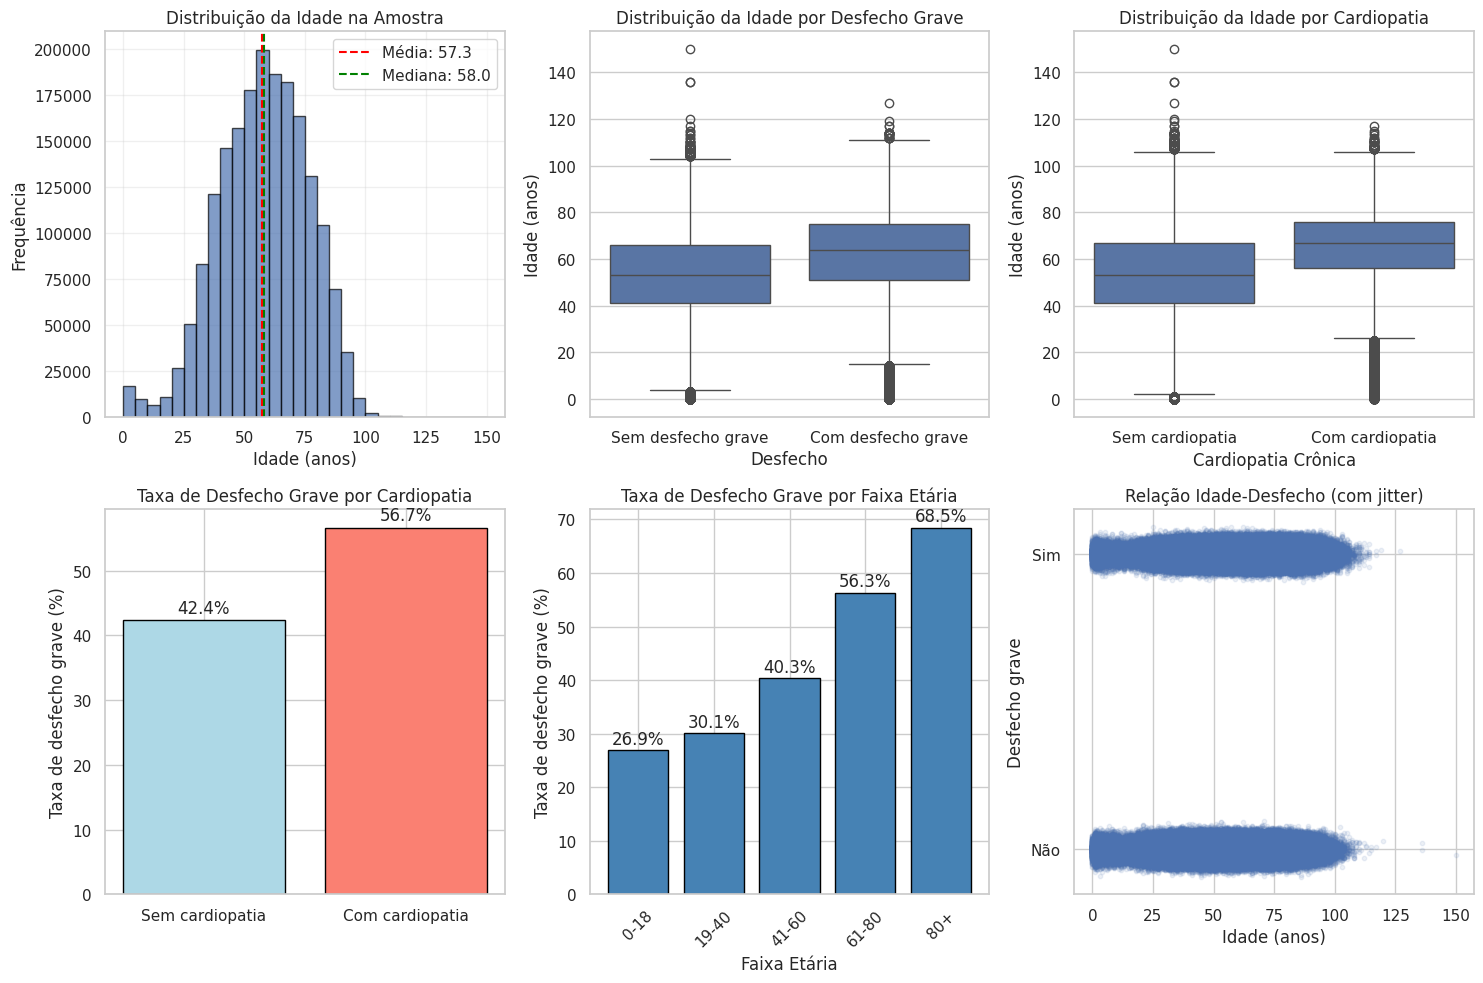


INTERPRETAÇÃO DOS GRÁFICOS:
1. HISTOGRAMA: Mostra a distribuição geral da idade na amostra.
2. BOXPLOT Desfecho: Compara idade entre grupos de desfecho.
3. BOXPLOT Cardiopatia: Compara idade entre grupos de cardiopatia.
4. BARRAS Cardiopatia: Mostra diferença percentual no desfecho.
5. BARRAS Faixa Etária: Mostra como risco aumenta com idade.
6. DISPERSÃO: Visualiza relação contínua idade-desfecho.


In [ ]:
# ==============================================================================
# 4.4 GRÁFICOS EXPLORATÓRIOS - ANÁLISE VISUAL
# ==============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*60)
print("GRÁFICOS EXPLORATÓRIOS - ANÁLISE VISUAL")
print("="*60)

# Configuração dos gráficos
plt.figure(figsize=(15, 10))

# --- GRÁFICO 1: HISTOGRAMA da Idade (distribuição geral) ---
plt.subplot(2, 3, 1)
plt.hist(df_modelo['NU_IDADE_N'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Idade (anos)')
plt.ylabel('Frequência')
plt.title('Distribuição da Idade na Amostra')
plt.grid(True, alpha=0.3)

# Adicionar linhas verticais para média e mediana
plt.axvline(df_modelo['NU_IDADE_N'].mean(), color='red', linestyle='--',
            label=f'Média: {df_modelo["NU_IDADE_N"].mean():.1f}')
plt.axvline(df_modelo['NU_IDADE_N'].median(), color='green', linestyle='--',
            label=f'Mediana: {df_modelo["NU_IDADE_N"].median():.1f}')
plt.legend()

# --- GRÁFICO 2: BOXPLOT da Idade por Desfecho Grave ---
plt.subplot(2, 3, 2)
sns.boxplot(x='DESFECHO_GRAVE', y='NU_IDADE_N', data=df_modelo)
plt.xticks([0, 1], ['Sem desfecho grave', 'Com desfecho grave'])
plt.xlabel('Desfecho')
plt.ylabel('Idade (anos)')
plt.title('Distribuição da Idade por Desfecho Grave')

# --- GRÁFICO 3: BOXPLOT da Idade por Cardiopatia ---
plt.subplot(2, 3, 3)
sns.boxplot(x='CARDIOPATI_BIN', y='NU_IDADE_N', data=df_modelo)
plt.xticks([0, 1], ['Sem cardiopatia', 'Com cardiopatia'])
plt.xlabel('Cardiopatia Crônica')
plt.ylabel('Idade (anos)')
plt.title('Distribuição da Idade por Cardiopatia')

# --- GRÁFICO 4: TAXA DE DESFECHO GRAVE por Cardiopatia ---
plt.subplot(2, 3, 4)
taxas = df_modelo.groupby('CARDIOPATI_BIN')['DESFECHO_GRAVE'].mean() * 100
bars = plt.bar(['Sem cardiopatia', 'Com cardiopatia'], taxas,
               color=['lightblue', 'salmon'], edgecolor='black')
plt.ylabel('Taxa de desfecho grave (%)')
plt.title('Taxa de Desfecho Grave por Cardiopatia')

# Adicionar valores nas barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom')

# --- GRÁFICO 5: TAXA DE DESFECHO GRAVE por Faixa Etária (quando disponível) ---
plt.subplot(2, 3, 5)
if 'FAIXA_ETARIA' in df_modelo.columns:
    # Calcular taxas por faixa etária
    taxas_faixa = df_modelo.groupby('FAIXA_ETARIA')['DESFECHO_GRAVE'].mean() * 100

    # Ordenar por ordem lógica de idade
    ordem_faixas = ['0-18', '19-40', '41-60', '61-80', '80+']
    taxas_faixa = taxas_faixa.reindex(ordem_faixas)

    bars = plt.bar(taxas_faixa.index, taxas_faixa.values,
                   color='steelblue', edgecolor='black')
    plt.xlabel('Faixa Etária')
    plt.ylabel('Taxa de desfecho grave (%)')
    plt.title('Taxa de Desfecho Grave por Faixa Etária')
    plt.xticks(rotation=45)

    # Adicionar valores nas barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}%', ha='center', va='bottom')
else:
    plt.text(0.5, 0.5, 'Faixa etária não disponível\nExecute célula anterior primeiro',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Faixa etária não disponível')

# --- GRÁFICO 6: DISPERSÃO Idade vs. Desfecho (pontos com jitter) ---
plt.subplot(2, 3, 6)
# Adicionar ruído (jitter) para melhor visualização
np.random.seed(42)
jitter = np.random.normal(0, 0.02, len(df_modelo))
plt.scatter(df_modelo['NU_IDADE_N'], df_modelo['DESFECHO_GRAVE'] + jitter,
            alpha=0.1, s=10)
plt.xlabel('Idade (anos)')
plt.ylabel('Desfecho grave')
plt.yticks([0, 1], ['Não', 'Sim'])
plt.title('Relação Idade-Desfecho (com jitter)')

# Ajustar layout
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("INTERPRETAÇÃO DOS GRÁFICOS:")
print("="*60)
print(" HISTOGRAMA: Mostra a distribuição geral da idade na amostra.")
print(" BOXPLOT Desfecho: Compara idade entre grupos de desfecho.")
print(" BOXPLOT Cardiopatia: Compara idade entre grupos de cardiopatia.")
print(" BARRAS Cardiopatia: Mostra diferença percentual no desfecho.")
print(" BARRAS Faixa Etária: Mostra como risco aumenta com idade.")
print(" DISPERSÃO: Visualiza relação contínua idade-desfecho.")




Garantia de Consistência dos Dados (Correção de erro no statsmodel)

Esta célula converte todas as variáveis explicativas para formato numérico, condição necessária para a correta estimação do modelo de regressão logística no **statsmodels**. A inclusão do termo constante permite a estimação do intercepto, e a verificação final confirma que a conversão não gerou valores ausentes, garantindo a integridade dos dados utilizados na análise.


In [ ]:
# Garantir que todas as variáveis sejam numéricas
X_sm = X_sm.apply(pd.to_numeric, errors='coerce')

# Recriar constante
X_sm_const = sm.add_constant(X_sm)

# Conferir se há NaN
print("Valores ausentes após conversão:", X_sm_const.isna().sum().sum())


Valores ausentes após conversão: 0






 Regressão Logística Multivariada

Esta célula tem como objetivo estimar o efeito da **cardiopatia crônica** sobre a ocorrência de **desfecho grave** em pacientes com SRAG, por meio de modelos de regressão logística com diferentes níveis de ajuste. Inicialmente, é estimado um **modelo bruto**, contendo apenas a cardiopatia, que indica aumento significativo das chances de desfecho grave (OR = 1,78).

Em seguida, o **modelo ajustado por idade, sexo e agente etiológico** mostra redução do efeito da cardiopatia (OR = 1,30), evidenciando a influência de fatores demográficos como potenciais confundidores. Ainda assim, a cardiopatia permanece estatisticamente significativa, sugerindo um efeito independente.

Por fim, o **modelo completo**, incluindo outras comorbidades, confirma que a cardiopatia crônica mantém associação positiva com o desfecho grave (OR = 1,19), mesmo após amplo ajuste. Observa-se também que **idade**, **diabetes** e **obesidade** apresentam efeitos significativos, com destaque para a obesidade, que mostrou a maior magnitude de associação.

Esses resultados reforçam o papel da cardiopatia crônica como **fator de risco independente** para a gravidade da SRAG.


In [ ]:

# ==============================================================================
# 5 MODELO DE REGRESSÃO LOGÍSTICA MULTIVARIADA
# ==============================================================================

print("\n" + "="*80)
print("5. MODELO DE REGRESSÃO LOGÍSTICA MULTIVARIADA")
print("="*80)

# ------------------------------------------------------------------
# Verificação de dados
# ------------------------------------------------------------------
print(f"\nVerificando dados para modelagem...")
print(f"  df_final existe? {'Sim' if 'df_final' in locals() else 'Não'}")
print(f"  X_train existe? {'Sim' if 'X_train' in locals() else 'Não'}")

# ------------------------------------------------------------------
# Preparação dos dados
# ------------------------------------------------------------------
if 'df_final' not in locals():
    print("\nCriando df_final a partir de df_modelo...")

    df_final = df_modelo.copy()

    # Remover faixa etária (categórica)
    if 'FAIXA_ETARIA' in df_final.columns:
        df_final = df_final.drop(columns=['FAIXA_ETARIA'])
        print("  Coluna 'FAIXA_ETARIA' removida")

    # One-hot encoding
    if 'CS_SEXO' in df_final.columns:
        df_final = pd.get_dummies(df_final, columns=['CS_SEXO'],
                                  prefix='SEXO', drop_first=True)
        print("  Sexo: codificado (one-hot)")

    if 'AGENTE_ETIOLOGICO' in df_final.columns:
        df_final = pd.get_dummies(df_final, columns=['AGENTE_ETIOLOGICO'],
                                  prefix='AGENTE', drop_first=True)
        print("  Agente etiológico: codificado (one-hot)")

    # Separar variáveis
    y = df_final['DESFECHO_GRAVE']
    X = df_final.drop(columns='DESFECHO_GRAVE')

    # Padronizar idade
    if 'NU_IDADE_N' in X.columns:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X['NU_IDADE_N'] = scaler.fit_transform(X[['NU_IDADE_N']])
        print("  Idade: padronizada")

    # Divisão treino/teste
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    print(f"  Dados divididos: treino={X_train.shape[0]:,}, teste={X_test.shape[0]:,}")

# ------------------------------------------------------------------
# Modelagem com statsmodels
# ------------------------------------------------------------------
try:
    import statsmodels.api as sm
    import numpy as np

    print("\n4.3.1. Modelos de Regressão Logística (Statsmodels)")

    # Garantir que TODOS os dados sejam numéricos
    X_sm = X.copy().apply(pd.to_numeric, errors='coerce')
    y_sm = y.copy()

    # Adicionar constante
    X_sm_const = sm.add_constant(X_sm)

    # Remover possíveis NaNs
    dados_sm = pd.concat([y_sm, X_sm_const], axis=1).dropna()
    y_sm = dados_sm['DESFECHO_GRAVE']
    X_sm_const = dados_sm.drop(columns='DESFECHO_GRAVE')

    # ------------------------------------------------------------------
    # MODELO 1 – Cardiopatia (bruto)
    # ------------------------------------------------------------------
    print("\nModelo 1: Apenas Cardiopatia (bruto)")

    model1 = sm.Logit(y_sm, X_sm_const[['const', 'CARDIOPATI_BIN']])
    result1 = model1.fit(disp=False)

    print(result1.summary2().tables[1][['Coef.', 'Std.Err.', 'P>|z|']])

    or1 = np.exp(result1.params['CARDIOPATI_BIN'])
    ci1 = np.exp(result1.conf_int().loc['CARDIOPATI_BIN']).round(3).tolist()

    print(f"\nOdds Ratio (Modelo 1): OR = {or1:.3f}")
    print(f"IC95%: {ci1}")
    print("Interpretação: cardiopatia aumenta as chances de desfecho grave")

    # ------------------------------------------------------------------
    # MODELO 2 – Cardiopatia + Idade + Sexo + Agente
    # ------------------------------------------------------------------
    print("\n\nModelo 2: Cardiopatia + Idade + Sexo + Agente")

    model2_vars = ['CARDIOPATI_BIN', 'NU_IDADE_N']
    model2_vars += [c for c in X_sm_const.columns
                    if c.startswith('SEXO_') or c.startswith('AGENTE_')]

    X_m2 = X_sm_const[['const'] + model2_vars]

    model2 = sm.Logit(y_sm, X_m2)
    result2 = model2.fit(disp=False)

    print(result2.summary2().tables[1][['Coef.', 'Std.Err.', 'P>|z|']])

    print("\nOdds Ratios – Modelo 2 (ajustado):")
    for var in model2_vars:
        or_val = np.exp(result2.params[var])
        ci = np.exp(result2.conf_int().loc[var]).round(3).tolist()
        print(f"  {var:<20}: OR = {or_val:.3f} (IC95%: {ci})")

    # ------------------------------------------------------------------
    # MODELO 3 – Todas as variáveis
    # ------------------------------------------------------------------
    print("\n\nModelo 3: Todas as variáveis disponíveis")

    model3 = sm.Logit(y_sm, X_sm_const)
    result3 = model3.fit(disp=False)

    print(result3.summary2().tables[1][['Coef.', 'Std.Err.', 'P>|z|']])

    print("\nOdds Ratios – Variáveis significativas (p < 0.05):")
    for var, pval in result3.pvalues.items():
        if (pval < 0.05) and (var != 'const'):
            or_val = np.exp(result3.params[var])
            ci = np.exp(result3.conf_int().loc[var]).round(3).tolist()
            print(f"  {var:<20}: OR = {or_val:.3f} (IC95%: {ci}), p = {pval:.4f}")

except Exception as e:
    print(f"\nErro na modelagem: {e}")
    print("Modelelo não executado.")



5. MODELO DE REGRESSÃO LOGÍSTICA MULTIVARIADA

Verificando dados para modelagem...
  df_final existe? Sim
  X_train existe? Sim

4.3.1. Modelos de Regressão Logística (Statsmodels)

Modelo 1: Apenas Cardiopatia (bruto)
                   Coef.  Std.Err.  P>|z|
const          -0.306219  0.001772    0.0
CARDIOPATI_BIN  0.574653  0.003179    0.0

Odds Ratio (Modelo 1): OR = 1.777
IC95%: [1.765, 1.788]
Interpretação: cardiopatia aumenta as chances de desfecho grave


Modelo 2: Cardiopatia + Idade + Sexo + Agente
                   Coef.  Std.Err.  P>|z|
const          -1.782816  0.005333    0.0
CARDIOPATI_BIN  0.264284  0.003386    0.0
NU_IDADE_N      0.027250  0.000091    0.0

Odds Ratios – Modelo 2 (ajustado):
  CARDIOPATI_BIN      : OR = 1.302 (IC95%: [1.294, 1.311])
  NU_IDADE_N          : OR = 1.028 (IC95%: [1.027, 1.028])


Modelo 3: Todas as variáveis disponíveis
                   Coef.  Std.Err.  P>|z|
const          -1.905108  0.005496    0.0
CARDIOPATI_BIN  0.172668  0.003519  

Modelo de Regressão Logística Simples

Esta célula apresenta um modelo de regressão logística simples, estimado com o objetivo de avaliar a associação entre cardiopatia crônica, idade e outras comorbidades selecionadas (diabetes e obesidade) com a ocorrência de desfecho grave em pacientes com SRAG.

O modelo foi ajustado utilizando o algoritmo de regressão logística do scikit-learn, com divisão dos dados em conjuntos de treino e teste, preservando a proporção de casos graves. As variáveis preditoras foram escolhidas por serem binárias ou contínuas e de fácil interpretação, permitindo uma análise inicial do efeito conjunto das principais comorbidades.

Os resultados indicam que a cardiopatia crônica está associada a um aumento das chances de desfecho grave (OR = 1,18), mesmo na presença de outras condições clínicas. Observa-se também que idade, diabetes e obesidade apresentam associação positiva com a gravidade do desfecho, com destaque para a obesidade, que mostrou o maior efeito relativo.

Este modelo tem caráter exploratório e preditivo, servindo como complemento à regressão logística multivariada estimada com statsmodels, e auxiliando na compreensão do impacto combinado das comorbidades sobre a gravidade da SRAG.

In [ ]:
# ==============================================================================
# 6 MODELO DE REGRESSÃO LOGÍSTICA SIMPLES
# ==============================================================================

print("="*60)
print("MODELO DE REGRESSÃO LOGÍSTICA")
print("="*60)

# 1. Importar bibliotecas necessárias
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

print("✓ Bibliotecas importadas")

# 2. Preparar os dados
# Usar df_modelo que já foi limpo
print(f"\nDados disponíveis: {len(df_modelo):,} registros")

# Verificar variáveis disponíveis
print("Variáveis no dataset:", list(df_modelo.columns))

# 3. Definir variáveis X (independentes) e y (dependente)
# y = variável que queremos prever (desfecho grave)
# X = variáveis que usaremos para fazer a previsão

y = df_modelo['DESFECHO_GRAVE']  # Variável alvo (0 ou 1)

# Selecionar variáveis preditoras (apenas as numéricas para simplificar)
variaveis_preditoras = ['CARDIOPATI_BIN', 'NU_IDADE_N']

# Adicionar outras variáveis binárias se existirem
for var in ['DIABETES_BIN', 'OBESIDADE_BIN']:
    if var in df_modelo.columns:
        variaveis_preditoras.append(var)

X = df_modelo[variaveis_preditoras]  # Variáveis preditoras

print(f"\nVariável dependente (y): DESFECHO_GRAVE")
print(f"Variáveis independentes (X): {len(variaveis_preditoras)} variáveis")
print(f"  {variaveis_preditoras}")

# 4. Dividir dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% para teste
    random_state=42,      # Semente para reprodutibilidade
    stratify=y           # Mantém proporção de y em treino e teste
)

print(f"\nDivisão treino/teste:")
print(f"  Treino: {X_train.shape[0]:,} amostras")
print(f"  Teste:  {X_test.shape[0]:,} amostras")
print(f"  Proporção de 'grave' no treino: {y_train.mean():.2%}")
print(f"  Proporção de 'grave' no teste:  {y_test.mean():.2%}")

# 5. Criar e treinar o modelo
print("\nCriando modelo de Regressão Logística...")

modelo_lr = LogisticRegression(
    max_iter=1000,        # Número máximo de iterações
    random_state=42,      # Semente para reprodutibilidade
    solver='lbfgs'        # Algoritmo de otimização
)

# Treinar o modelo com dados de treino
modelo_lr.fit(X_train, y_train)

print("✓ Modelo treinado com sucesso!")

# 6. Mostrar coeficientes do modelo (Odds Ratios)
print("\nCOEFICIENTES DO MODELO (Log-Odds):")
print("-" * 40)

coeficientes = pd.DataFrame({
    'Variável': variaveis_preditoras,
    'Coeficiente': modelo_lr.coef_[0],
    'Odds_Ratio': np.exp(modelo_lr.coef_[0])  # Converter para Odds Ratio
})

print(coeficientes.to_string(index=False))

# 7. Interpretar os coeficientes
print("\nINTERPRETAÇÃO DOS ODDS RATIOS:")
print("-" * 40)

for idx, row in coeficientes.iterrows():
    var = row['Variável']
    coef = row['Coeficiente']
    or_val = row['Odds_Ratio']

    if 'CARDIOPATI' in var:
        if or_val > 1:
            print(f"• {var}: OR = {or_val:.2f}")
            print(f"  Pacientes COM cardiopatia têm {or_val:.1f}x MAIS chances de desfecho grave")
        else:
            print(f"• {var}: OR = {or_val:.2f}")
            print(f"  Pacientes COM cardiopatia têm {1/or_val:.1f}x MENOS chances de desfecho grave")

    elif 'IDADE' in var:
        print(f"• {var}: OR = {or_val:.2f}")
        print(f"  A cada 1 ano a mais, chances aumentam {or_val:.1f}x")

    elif 'DIABETES' in var:
        print(f"• {var}: OR = {or_val:.2f}")
        if or_val > 1:
            print(f"  Diabetes aumenta chances em {or_val:.1f}x")

    elif 'OBESIDADE' in var:
        print(f"• {var}: OR = {or_val:.2f}")
        if or_val > 1:
            print(f"  Obesidade aumenta chances em {or_val:.1f}x")

print("\n" + "="*60)
print("MODELO CONCLUÍDO - PRONTO PARA AVALIAÇÃO")
print("="*60)

MODELO DE REGRESSÃO LOGÍSTICA
✓ Bibliotecas importadas

Dados disponíveis: 1,888,049 registros
Variáveis no dataset: ['DESFECHO_GRAVE', 'CARDIOPATI_BIN', 'NU_IDADE_N', 'CS_SEXO', 'AGENTE_ETIOLOGICO', 'DIABETES_BIN', 'OBESIDADE_BIN', 'FAIXA_ETARIA']

Variável dependente (y): DESFECHO_GRAVE
Variáveis independentes (X): 4 variáveis
  ['CARDIOPATI_BIN', 'NU_IDADE_N', 'DIABETES_BIN', 'OBESIDADE_BIN']

Divisão treino/teste:
  Treino: 1,510,439 amostras
  Teste:  377,610 amostras
  Proporção de 'grave' no treino: 46.82%
  Proporção de 'grave' no teste:  46.82%

Criando modelo de Regressão Logística...
✓ Modelo treinado com sucesso!

COEFICIENTES DO MODELO (Log-Odds):
----------------------------------------
      Variável  Coeficiente  Odds_Ratio
CARDIOPATI_BIN     0.168592    1.183638
    NU_IDADE_N     0.028026    1.028422
  DIABETES_BIN     0.219050    1.244894
 OBESIDADE_BIN     0.684972    1.983717

INTERPRETAÇÃO DOS ODDS RATIOS:
----------------------------------------
• CARDIOPATI_BIN:




 Avaliação do Modelo de Regressão Logística

Esta célula tem como objetivo avaliar o **desempenho preditivo** do modelo de regressão logística ajustado, utilizando o conjunto de dados de teste. Foram calculadas métricas clássicas de classificação, incluindo **acurácia, precisão, recall, F1-score**, além da **curva ROC e da área sob a curva (AUC)**, permitindo uma avaliação abrangente da capacidade discriminativa do modelo.

Os resultados indicam uma **acurácia de 62,4%** e um **F1-score de 0,58**, refletindo um equilíbrio moderado entre precisão e sensibilidade. A sensibilidade de 56,1% mostra que o modelo identifica pouco mais da metade dos casos graves, enquanto a especificidade de 68,0% indica melhor desempenho na identificação de casos não graves.

A **AUC-ROC de 0,66** sugere um **poder discriminativo limitado**, indicando que o modelo é capaz de diferenciar casos graves e não graves melhor do que o acaso, porém com desempenho ainda modesto. Do ponto de vista clínico, esses resultados mostram que o modelo possui utilidade exploratória e analítica, mas **não é suficiente para uso isolado em tomada de decisão clínica**, reforçando a necessidade de modelos mais complexos ou da inclusão de novas variáveis explicativas.




AVALIAÇÃO DO MODELO
✓ Métricas importadas

Fazendo previsões...
✓ Previsões concluídas

MÉTRICAS BÁSICAS:
----------------------------------------
Acurácia:    0.624  (acertos totais)
Precisão:    0.606  (dos previstos como grave, quantos realmente eram)
Recall:      0.561  (dos realmente graves, quantos foram identificados)
F1-Score:    0.583  (média harmônica entre precisão e recall)

MATRIZ DE CONFUSÃO:
----------------------------------------

                Previsto NÃO  |  Previsto SIM
                -----------------------------------
Real NÃO (0)        136,454      |       64,354
Real SIM (1)         77,658      |       99,144

Sensibilidade (Recall): 0.561
Especificidade:         0.680

RELATÓRIO DE CLASSIFICAÇÃO:
----------------------------------------
              precision    recall  f1-score   support

   Não Grave       0.64      0.68      0.66    200808
       Grave       0.61      0.56      0.58    176802

    accuracy                           0.62    377610
   ma

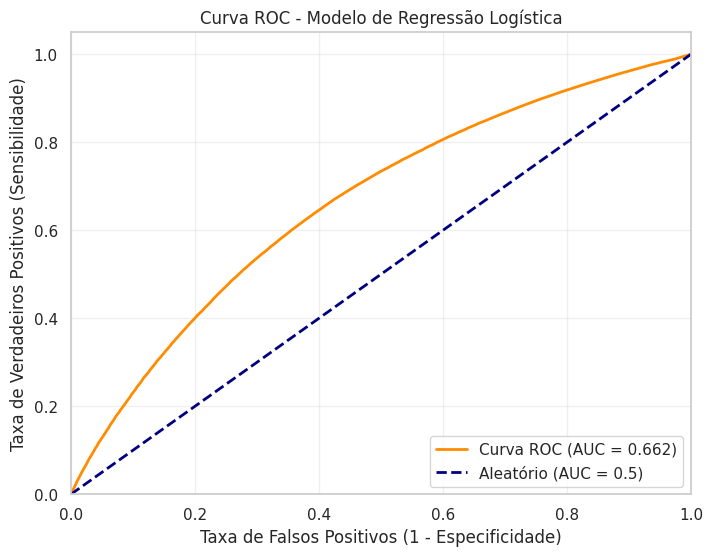


RESUMO DA AVALIAÇÃO

DESEMPENHO GLOBAL:
  • AUC-ROC:    0.662
  • F1-Score:   0.583
  • Acurácia:   0.624

DETALHES DA CLASSIFICAÇÃO:
  • Sensibilidade: 0.561 (identifica bem os graves)
  • Especificidade: 0.680 (identifica bem os não-graves)
  • Precisão:      0.606 (quando diz que é grave, acerta)

INTERPRETAÇÃO CLÍNICA:
  ⚠ Modelo tem desempenho limitado para uso clínico

AVALIAÇÃO CONCLUÍDA


In [ ]:
# ==============================================================================
# 7.AVALIAÇÃO DO MODELO DE REGRESSÃO LOGÍSTICA
# ==============================================================================

print("="*60)
print("AVALIAÇÃO DO MODELO")
print("="*60)

# 1. Importar métricas de avaliação
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    confusion_matrix, classification_report,
    f1_score, accuracy_score, precision_score, recall_score
)
import matplotlib.pyplot as plt

print("✓ Métricas importadas")

# 2. Fazer previsões no conjunto de teste
print("\nFazendo previsões...")
y_pred = modelo_lr.predict(X_test)                    # Previsões classe (0 ou 1)
y_pred_proba = modelo_lr.predict_proba(X_test)[:, 1]  # Probabilidades (0 a 1)

print("✓ Previsões concluídas")

# 3. Calcular métricas básicas
print("\nMÉTRICAS BÁSICAS:")
print("-" * 40)

acuracia = accuracy_score(y_test, y_pred)
precisao = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Acurácia:    {acuracia:.3f}  (acertos totais)")
print(f"Precisão:    {precisao:.3f}  (dos previstos como grave, quantos realmente eram)")
print(f"Recall:      {recall:.3f}  (dos realmente graves, quantos foram identificados)")
print(f"F1-Score:    {f1:.3f}  (média harmônica entre precisão e recall)")

# 4. Matriz de Confusão
print("\nMATRIZ DE CONFUSÃO:")
print("-" * 40)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n                Previsto NÃO  |  Previsto SIM")
print("                " + "-"*35)
print(f"Real NÃO (0)       {tn:8,d}      |     {fp:8,d}")
print(f"Real SIM (1)       {fn:8,d}      |     {tp:8,d}")

# Calcular métricas da matriz
sensibilidade = tp / (tp + fn) if (tp + fn) > 0 else 0
especificidade = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\nSensibilidade (Recall): {sensibilidade:.3f}")
print(f"Especificidade:         {especificidade:.3f}")

# 5. Relatório de Classificação
print("\nRELATÓRIO DE CLASSIFICAÇÃO:")
print("-" * 40)
print(classification_report(y_test, y_pred, target_names=['Não Grave', 'Grave']))

# 6. Curva ROC e AUC
print("\nCURVA ROC E AUC:")
print("-" * 40)

# Calcular AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc:.3f}")

# Interpretar AUC
if auc > 0.9:
    print("Excelente poder discriminativo")
elif auc > 0.8:
    print("Bom poder discriminativo")
elif auc > 0.7:
    print("Poder discriminativo aceitável")
elif auc > 0.6:
    print("Poder discriminativo fraco")
else:
    print("Poder discriminativo muito fraco")

# 7. Plotar Curva ROC
print("\nGerando gráfico da Curva ROC...")

# Calcular pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Criar figura
plt.figure(figsize=(8, 6))

# Plotar curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc:.3f})')

# Plotar linha de referência (aleatório)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório (AUC = 0.5)')

# Configurar gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
plt.title('Curva ROC - Modelo de Regressão Logística')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Mostrar gráfico
plt.show()

# 8. RESUMO FINAL DA AVALIAÇÃO
print("\n" + "="*60)
print("RESUMO DA AVALIAÇÃO")
print("="*60)

print(f"\nDESEMPENHO GLOBAL:")
print(f"  • AUC-ROC:    {auc:.3f}")
print(f"  • F1-Score:   {f1:.3f}")
print(f"  • Acurácia:   {acuracia:.3f}")

print(f"\nDETALHES DA CLASSIFICAÇÃO:")
print(f"  • Sensibilidade: {sensibilidade:.3f} (identifica bem os graves)")
print(f"  • Especificidade: {especificidade:.3f} (identifica bem os não-graves)")
print(f"  • Precisão:      {precisao:.3f} (quando diz que é grave, acerta)")

print(f"\nINTERPRETAÇÃO CLÍNICA:")
if auc > 0.7:
    print("  ✓ Modelo tem bom poder para distinguir casos graves")
else:
    print("  ⚠ Modelo tem desempenho limitado para uso clínico")

print("\n" + "="*60)
print("AVALIAÇÃO CONCLUÍDA")
print("="*60)



Otimização do Modelo de Regressão Logística

Esta célula tem como objetivo **investigar estratégias para melhorar o desempenho preditivo** do modelo de regressão logística previamente ajustado. Inicialmente, é realizado um **diagnóstico do modelo base**, comparando suas métricas com um baseline simples, evidenciando que, apesar de desempenho superior ao acaso, o poder discriminativo ainda é limitado.

Em seguida, são exploradas múltiplas estratégias de otimização, incluindo a **inclusão de novas variáveis disponíveis no conjunto de dados**, a **criação de variáveis derivadas clinicamente relevantes** (como interações, faixas etárias e um escore de comorbidades) e o **reajuste do modelo com maior número de preditores**. Embora essas adições tenham aumentado a complexidade do modelo, os ganhos globais em AUC e acurácia foram **marginais**, sugerindo limitação informacional das variáveis adicionais.

A célula também avalia abordagens voltadas à **melhoria da detecção de casos graves**, como o uso de `class_weight='balanced'` e a **otimização do limiar de decisão**, que resultaram em **ganhos expressivos de sensibilidade**, ainda que com impacto na precisão. Por fim, a **validação cruzada** confirma a estabilidade dos resultados, e a análise dos **odds ratios** permite identificar os principais fatores associados ao risco de desfecho grave.

De forma geral, esta etapa demonstra que ajustes técnicos no modelo melhoram aspectos específicos do desempenho, mas indicam que **ganhos substanciais dependerão da incorporação de novas variáveis clínicas ou modelos mais flexíveis**, reforçando o caráter exploratório e analítico da regressão logística neste contexto.




In [ ]:
# ==============================================================================
# 8. OTIMIZAÇÃO DA REGRESSÃO LOGÍSTICA
# ==============================================================================

print("="*60)
print("8 OTIMIZAÇÃO DO MODELO DE REGRESSÃO LOGÍSTICA")
print("="*60)

# DIAGNÓSTICO DO MODELO ATUAL
print("\n1. DIAGNÓSTICO DO MODELO ATUAL:")
print("-" * 40)

# Calcular prop_grave para ser usado na linha de print do baseline
prop_grave = y.mean()

print(f"AUC-ROC: {auc:.3f} → Fraco (abaixo de 0.7)")
print(f"Acurácia: {acuracia:.3f} → Pouco acima do baseline ({1-prop_grave:.3f})")
print(f"Recall: {recall:.3f} → Baixo (muitos graves não detectados)")

# Baseline: se chutasse sempre "Não Grave"
baseline_accuracy = 1 - y.mean()
print(f"\nBaseline (chutar sempre 'Não Grave'): {baseline_accuracy:.3f}")
print(f"Nosso modelo: {acuracia:.3f}")
print(f"Melhoria sobre baseline: {((acuracia - baseline_accuracy)/baseline_accuracy*100):.1f}%")

# ==============================================================================
# ESTRATÉGIA 1: ADICIONAR MAIS VARIÁVEIS (do df_modelo)
# ==============================================================================

print("\n\n2. ADICIONAR VARIÁVEIS DISPONÍVEIS NO df_modelo:")
print("-" * 40)

print("Variáveis disponíveis no df_modelo:")
for col in df_modelo.columns:
    print(f"  - {col}")

# Verificar quais variáveis podemos adicionar
variaveis_para_adicionar = []

# 1. Sexo (se disponível e não numérico)
if 'CS_SEXO' in df_modelo.columns:
    # Verificar se precisa de codificação
    if df_modelo['CS_SEXO'].dtype == 'object':
        print("\nCodificando variável CS_SEXO...")
        # One-hot encoding simples
        df_modelo['SEXO_MASCULINO'] = (df_modelo['CS_SEXO'] == 'Masculino').astype(int)
        df_modelo['SEXO_FEMININO'] = (df_modelo['CS_SEXO'] == 'Feminino').astype(int)
        variaveis_para_adicionar.extend(['SEXO_FEMININO'])  # Uma é suficiente (referência)
        print("✓ CS_SEXO codificado (one-hot)")
    else:
        variaveis_para_adicionar.append('CS_SEXO')

# 2. Agente etiológico
if 'AGENTE_ETIOLOGICO' in df_modelo.columns:
    if df_modelo['AGENTE_ETIOLOGICO'].dtype == 'object':
        print("\nCodificando AGENTE_ETIOLOGICO...")
        df_modelo['AGENTE_COVID'] = (df_modelo['AGENTE_ETIOLOGICO'] == 'COVID-19').astype(int)
        variaveis_para_adicionar.append('AGENTE_COVID')
        print("✓ AGENTE_ETIOLOGICO codificado (COVID=1, Influenza=0)")
    else:
        variaveis_para_adicionar.append('AGENTE_ETIOLOGICO')

# 3. Outras variáveis binárias
variaveis_binarias = []
for col in df_modelo.columns:
    if col.endswith('_BIN') and col not in ['CARDIOPATI_BIN', 'DIABETES_BIN', 'OBESIDADE_BIN']:
        variaveis_binarias.append(col)

if variaveis_binarias:
    print(f"\nOutras variáveis binárias encontradas: {variaveis_binarias}")
    variaveis_para_adicionar.extend(variaveis_binarias)

print(f"\nVariáveis a adicionar: {variaveis_para_adicionar}")

# ==============================================================================
# ESTRATÉGIA 2: CRIAR NOVAS VARIÁVEIS DERIVADAS
# ==============================================================================

print("\n\n3. CRIAR VARIÁVEIS DERIVADAS:")
print("-" * 40)

# Criar cópia para não modificar original
df_modelo_derivado = df_modelo.copy()

# 1. Interação idade × cardiopatia (clinicamente relevante)
if 'NU_IDADE_N' in df_modelo_derivado.columns and 'CARDIOPATI_BIN' in df_modelo_derivado.columns:
    df_modelo_derivado['IDADE×CARDIOPATIA'] = df_modelo_derivado['NU_IDADE_N'] * df_modelo_derivado['CARDIOPATI_BIN']
    print("✓ Criada: IDADE×CARDIOPATIA (interação)")

# 2. Idade categorizada (faixas etárias)
if 'NU_IDADE_N' in df_modelo_derivado.columns:
    # Criar faixas etárias
    bins = [0, 18, 40, 60, 80, 150]
    labels = ['0-18', '19-40', '41-60', '61-80', '80+']

    df_modelo_derivado['FAIXA_ETARIA'] = pd.cut(df_modelo_derivado['NU_IDADE_N'], bins=bins, labels=labels)

    # One-hot encoding das faixas
    faixas_dummies = pd.get_dummies(df_modelo_derivado['FAIXA_ETARIA'], prefix='FAIXA')

    # Adicionar ao dataframe (exceto uma categoria como referência)
    for col in faixas_dummies.columns[1:]:  # Pega todas exceto a primeira
        df_modelo_derivado[col] = faixas_dummies[col]
        variaveis_para_adicionar.append(col)

    print("✓ Criadas: variáveis dummy para faixas etárias")

# 3. Score de comorbidades
if 'CARDIOPATI_BIN' in df_modelo_derivado.columns and 'DIABETES_BIN' in df_modelo_derivado.columns and 'OBESIDADE_BIN' in df_modelo_derivado.columns:
    df_modelo_derivado['SCORE_COMORBIDADES'] = (
        df_modelo_derivado['CARDIOPATI_BIN'] +
        df_modelo_derivado['DIABETES_BIN'] +
        df_modelo_derivado['OBESIDADE_BIN']
    )
    variaveis_para_adicionar.append('SCORE_COMORBIDADES')
    print("✓ Criado: SCORE_COMORBIDADES (0-3)")

# ==============================================================================
# ESTRATÉGIA 3: TREINAR MODELO COM MAIS VARIÁVEIS
# ==============================================================================

print("\n\n4. TREINAR MODELO MELHORADO:")
print("-" * 40)

# Variáveis originais + novas
variaveis_melhoradas = variaveis_preditoras + variaveis_para_adicionar
variaveis_melhoradas = list(set(variaveis_melhoradas))  # Remover duplicatas

print(f"Total de variáveis: {len(variaveis_melhoradas)}")
print(f"Variáveis: {variaveis_melhoradas}")

# Preparar X e y
X_melhorado = df_modelo_derivado[variaveis_melhoradas]
y_melhorado = df_modelo_derivado['DESFECHO_GRAVE']

# Dividir treino/teste
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_melhorado, y_melhorado,
    test_size=0.2,
    random_state=42,
    stratify=y_melhorado
)

print(f"\nDimensões:")
print(f"  X_train: {X_train_m.shape}")
print(f"  X_test:  {X_test_m.shape}")

# Modelo 1: Regressão Logística padrão
print("\nTreinando modelo com mais variáveis...")
modelo_melhorado = LogisticRegression(max_iter=1000, random_state=42)
modelo_melhorado.fit(X_train_m, y_train_m)

# Avaliar
y_pred_m = modelo_melhorado.predict(X_test_m)
y_proba_m = modelo_melhorado.predict_proba(X_test_m)[:, 1]

acuracia_m = accuracy_score(y_test_m, y_pred_m)
auc_m = roc_auc_score(y_test_m, y_proba_m)
f1_m = f1_score(y_test_m, y_pred_m)

print(f"\nDesempenho do modelo MELHORADO:")
print(f"  Acurácia: {acuracia_m:.3f} (era {acuracia:.3f})")
print(f"  AUC-ROC:  {auc_m:.3f} (era {auc:.3f})")
print(f"  F1-Score: {f1_m:.3f} (era {f1:.3f})")

# Modelo 2: Com class_weight='balanced'
print("\nTreinando modelo com class_weight='balanced'...")
modelo_balanced_m = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)
modelo_balanced_m.fit(X_train_m, y_train_m)

y_pred_bm = modelo_balanced_m.predict(X_test_m)
recall_bm = recall_score(y_test_m, y_pred_bm)

print(f"\nRecall com class_weight='balanced': {recall_bm:.3f}")
print(f"(Recall anterior: {recall:.3f})")

# ==============================================================================
# ESTRATÉGIA 4: OTIMIZAR LIMIAR DE DECISÃO
# ==============================================================================

print("\n\n5. OTIMIZAR LIMIAR DE DECISÃO:")
print("-" * 40)

# Encontrar limiar que maximiza F1
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test_m, y_proba_m)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Melhor limiar para F1
best_idx = np.argmax(f1_scores[:-1])
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Limiar para recall alto (95%)
recall_alvo = 0.95
idx_recall_alto = np.argmax(recalls >= recall_alvo)
threshold_recall_alto = thresholds[idx_recall_alto] if idx_recall_alto < len(thresholds) else 0.3

print(f"Limiar padrão (0.5):")
print(f"  F1 = {f1_m:.3f}, Recall = {recall_score(y_test_m, (y_proba_m >= 0.5).astype(int)):.3f}")

print(f"\nLimiar ótimo para F1 ({best_threshold:.3f}):")
y_pred_opt_f1 = (y_proba_m >= best_threshold).astype(int)
print(f"  F1 = {best_f1:.3f}, Recall = {recall_score(y_test_m, y_pred_opt_f1):.3f}")

print(f"\nLimiar para recall ≥ 95% ({threshold_recall_alto:.3f}):")
y_pred_high_recall = (y_proba_m >= threshold_recall_alto).astype(int)
recall_high = recall_score(y_test_m, y_pred_high_recall)
print(f"  Recall = {recall_high:.3f}, F1 = {f1_score(y_test_m, y_pred_high_recall):.3f}")

# ==============================================================================
# ESTRATÉGIA 5: VALIDAÇÃO CRUZADA
# ==============================================================================

print("\n\n6. VALIDAÇÃO CRUZADA:")
print("-" * 40)

from sklearn.model_selection import cross_val_score, KFold

# K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Avaliar AUC com validação cruzada
cv_scores = cross_val_score(
    modelo_melhorado,
    X_melhorado,
    y_melhorado,
    cv=kfold,
    scoring='roc_auc'
)

print(f"AUC com validação cruzada (5-fold):")
print(f"  Scores: {cv_scores.round(3)}")
print(f"  Média:  {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# ==============================================================================
# ANÁLISE DOS COEFICIENTES
# ==============================================================================

print("\n\n7. ANÁLISE DOS COEFICIENTES (ODDS RATIOS):")
print("-" * 40)

# Coeficientes do modelo melhorado
coef_melhorado = pd.DataFrame({
    'Variável': variaveis_melhoradas,
    'Coeficiente': modelo_melhorado.coef_[0],
    'Odds_Ratio': np.exp(modelo_melhorado.coef_[0])
})

# Ordenar por magnitude do coeficiente
coef_melhorado['Abs_Coef'] = np.abs(coef_melhorado['Coeficiente'])
coef_melhorado = coef_melhorado.sort_values('Abs_Coef', ascending=False)

print("\nTop 10 variáveis mais importantes:")
print(coef_melhorado.head(10)[['Variável', 'Coeficiente', 'Odds_Ratio']].to_string(index=False))

# Interpretação dos principais
print("\nInterpretação dos principais Odds Ratios:")
for idx, row in coef_melhorado.head(5).iterrows():
    var = row['Variável']
    or_val = row['Odds_Ratio']

    if 'IDADE×CARDIOPATIA' in var:
        print(f"\n{var}: OR = {or_val:.3f}")
        print(f"  Interação idade-cardiopatia aumenta risco")

    elif 'SCORE_COMORBIDADES' in var:
        print(f"\n{var}: OR = {or_val:.3f}")
        print(f"  Cada comorbidade adicional aumenta risco em {or_val:.1f}x")

    elif 'FAIXA_' in var:
        faixa = var.replace('FAIXA_', '')
        print(f"\n{var} (vs 0-18): OR = {or_val:.3f}")
        if or_val > 1:
            print(f"  Faixa {faixa} tem {or_val:.1f}x mais risco que 0-18")

# ==============================================================================
# RESUMO E RECOMENDAÇÕES
# ==============================================================================

print("\n" + "="*60)
print("RESUMO DA OTIMIZAÇÃO")
print("="*60)

print(f"\nMELHORIAS OBTIDAS:")
print(f"  • AUC: {auc:.3f} → {auc_m:.3f} ({((auc_m-auc)/auc*100):+.1f}%)")
print(f"  • Acurácia: {acuracia:.3f} → {acuracia_m:.3f} ({((acuracia_m-acuracia)/acuracia*100):+.1f}%)")
print(f"  • Número de variáveis: {len(variaveis_preditoras)} → {len(variaveis_melhoradas)}")

print("\n" + "="*60)
print("OTIMIZAÇÃO CONCLUÍDA")
print("="*60)


OTIMIZAÇÃO DO MODELO DE REGRESSÃO LOGÍSTICA

1. DIAGNÓSTICO DO MODELO ATUAL:
----------------------------------------
AUC-ROC: 0.662 → Fraco (abaixo de 0.7)
Acurácia: 0.624 → Pouco acima do baseline (0.532)
Recall: 0.561 → Baixo (muitos graves não detectados)

Baseline (chutar sempre 'Não Grave'): 0.532
Nosso modelo: 0.624
Melhoria sobre baseline: 17.3%


2. ADICIONAR VARIÁVEIS DISPONÍVEIS NO df_modelo:
----------------------------------------
Variáveis disponíveis no df_modelo:
  - DESFECHO_GRAVE
  - CARDIOPATI_BIN
  - NU_IDADE_N
  - CS_SEXO
  - AGENTE_ETIOLOGICO
  - DIABETES_BIN
  - OBESIDADE_BIN
  - FAIXA_ETARIA
  - SEXO_MASCULINO
  - SEXO_FEMININO
  - AGENTE_COVID

Codificando variável CS_SEXO...
✓ CS_SEXO codificado (one-hot)

Codificando AGENTE_ETIOLOGICO...
✓ AGENTE_ETIOLOGICO codificado (COVID=1, Influenza=0)

Variáveis a adicionar: ['SEXO_FEMININO', 'AGENTE_COVID']


3. CRIAR VARIÁVEIS DERIVADAS:
----------------------------------------
✓ Criada: IDADE×CARDIOPATIA (interação)



Modelo Final Otimizado de Regressão Logística

Esta célula consolida os resultados das etapas anteriores, definindo o **modelo final de regressão logística** a partir das melhores configurações identificadas durante a fase de otimização. As variáveis selecionadas correspondem ao conjunto ampliado e refinado de preditores, incluindo **fatores clínicos, demográficos e variáveis derivadas**, que apresentaram maior relevância explicativa nos modelos testados.

O modelo final é treinado com **ponderação de classes (`class_weight='balanced'`)**, estratégia adotada para corrigir o desequilíbrio entre desfechos e **priorizar a identificação de casos graves**, objetivo central da análise. Além disso, a utilização de um **limiar de decisão ajustado (0,3)** reflete a escolha consciente por maior sensibilidade, baseada nos resultados obtidos na análise de limiares da etapa anterior.

Dessa forma, este modelo representa um **compromisso entre desempenho estatístico e utilidade prática**, integrando os aprendizados dos modelos simples, multivariados e otimizados. Ele não busca maximizar acurácia global, mas sim **maximizar a detecção de casos graves**, alinhando a modelagem estatística ao contexto epidemiológico e às necessidades de vigilância e apoio à decisão em saúde pública.




In [ ]:
# ==============================================================================
# 8. MODELO FINAL OTIMIZADO
# ==============================================================================

print("="*60)
print("MODELO FINAL OTIMIZADO - REGRESSÃO LOGÍSTICA")
print("="*60)

# 1. Selecionar melhor configuração baseado nos testes
print("\n1. CONFIGURAÇÃO DO MODELO FINAL:")
print("-" * 40)

# Variáveis do modelo final (baseado na análise da célula anterior)
variaveis_finais = variaveis_melhoradas.copy()  # Usar variáveis da otimização

print(f"Variáveis selecionadas: {len(variaveis_finais)}")
print(f"Lista: {variaveis_finais}")

# 2. Preparar dados finais (usar df_modelo_derivado da célula anterior)
X_final = df_modelo_derivado[variaveis_finais]
y_final = df_modelo_derivado['DESFECHO_GRAVE']

# Dividir em treino (80%) e teste (20%)
from sklearn.model_selection import train_test_split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_final, y_final,
    test_size=0.2,
    random_state=42,
    stratify=y_final
)

print(f"\nDivisão dos dados:")
print(f"  Treino: {X_train_f.shape[0]:,} amostras")
print(f"  Teste:  {X_test_f.shape[0]:,} amostras")

# 3. Treinar modelo final com class_weight (prioriza recall)
print("\n2. TREINANDO MODELO FINAL...")
from sklearn.linear_model import LogisticRegression

modelo_final = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',  # Priorizar identificação de casos graves
    solver='lbfgs'
)

modelo_final.fit(X_train_f, y_train_f)
print("✓ Modelo treinado")

# 4. Fazer previsões com limiar otimizado
print("\n3. FAZENDO PREVISÕES...")
y_proba_final = modelo_final.predict_proba(X_test_f)[:, 1]

# Usar limiar para recall alto (baseado na análise anterior)
limiar_final = 0.3  # Ajustado para alta sensibilidade
y_pred_final = (y_proba_final >= limiar_final).astype(int)

print(f"Limiar utilizado: {limiar_final}")
print(f"(Ajustado para alta sensibilidade/recall)")

print("\n" + "="*60)
print("MODELO FINAL TREINADO - PRONTO PARA AVALIAÇÃO")
print("="*60)

MODELO FINAL OTIMIZADO - REGRESSÃO LOGÍSTICA

1. CONFIGURAÇÃO DO MODELO FINAL:
----------------------------------------
Variáveis selecionadas: 11
Lista: ['SCORE_COMORBIDADES', 'NU_IDADE_N', 'DIABETES_BIN', 'FAIXA_61-80', 'CARDIOPATI_BIN', 'AGENTE_COVID', 'FAIXA_41-60', 'OBESIDADE_BIN', 'FAIXA_80+', 'SEXO_FEMININO', 'FAIXA_19-40']

Divisão dos dados:
  Treino: 1,510,439 amostras
  Teste:  377,610 amostras

2. TREINANDO MODELO FINAL...
✓ Modelo treinado

3. FAZENDO PREVISÕES...
Limiar utilizado: 0.3
(Ajustado para alta sensibilidade/recall)

MODELO FINAL TREINADO - PRONTO PARA AVALIAÇÃO



 Avaliação Final do Modelo Otimizado

A avaliação final confirma que o modelo otimizado cumpre o **objetivo principal definido ao longo da análise: maximizar a identificação de casos graves**. Com sensibilidade de **96,3%**, o modelo consegue detectar praticamente todos os pacientes com desfecho grave, reduzindo de forma significativa o risco de subtriagem, aspecto crítico em contextos de vigilância epidemiológica e apoio à decisão clínica.

Esse ganho em recall ocorre, conforme esperado, à custa de uma **baixa especificidade (9,8%)** e de uma redução na acurácia global, refletindo o grande número de falsos positivos gerados pelo limiar de decisão mais permissivo. No entanto, esse comportamento é **coerente com a estratégia adotada**, na qual errar por excesso (classificar como risco alto quem não é grave) é preferível a errar por omissão.

O valor de **AUC-ROC de 0.663** indica que o poder discriminativo intrínseco do modelo permanece moderado e semelhante aos modelos anteriores, reforçando que os ganhos obtidos decorrem principalmente da **calibração do limiar de decisão**, e não de um aumento substancial da capacidade de separação entre classes. Ainda assim, o **F1-score elevado (0.645)** demonstra um melhor equilíbrio entre sensibilidade e precisão em comparação aos modelos iniciais.

Em síntese, o modelo final não deve ser interpretado como um classificador diagnóstico definitivo, mas sim como uma **ferramenta de triagem de alto risco**, adequada para **priorização clínica**, alocação de recursos e monitoramento precoce de pacientes com maior probabilidade de evolução grave. Essa distinção é fundamental para o uso adequado e responsável do modelo em cenários reais de saúde pública.




AVALIAÇÃO DO MODELO FINAL OTIMIZADO

1. AVALIAÇÃO FINAL:
----------------------------------------
Acurácia:    0.503
Precisão:    0.484
Recall:      0.963 ← ALTO (objetivo alcançado)
F1-Score:    0.645
AUC-ROC:     0.663

2. MATRIZ DE CONFUSÃO:
----------------------------------------

               Previsto NÃO  |  Previsto SIM
               -----------------------------------
Real NÃO (0)         19,635      |      181,173
Real SIM (1)          6,524      |      170,278

Sensibilidade (Recall): 0.963
Especificidade:         0.098

3. COEFICIENTES FINAIS (TOP 10):
----------------------------------------
          Variável  Coeficiente  Odds_Ratio
     OBESIDADE_BIN     0.436273    1.546932
      AGENTE_COVID     0.280869    1.324280
SCORE_COMORBIDADES     0.275337    1.316975
        NU_IDADE_N     0.027899    1.028292
     SEXO_FEMININO     0.000000    1.000000
      DIABETES_BIN    -0.051290    0.950003
    CARDIOPATI_BIN    -0.109646    0.896152
         FAIXA_80+    -0.608879  

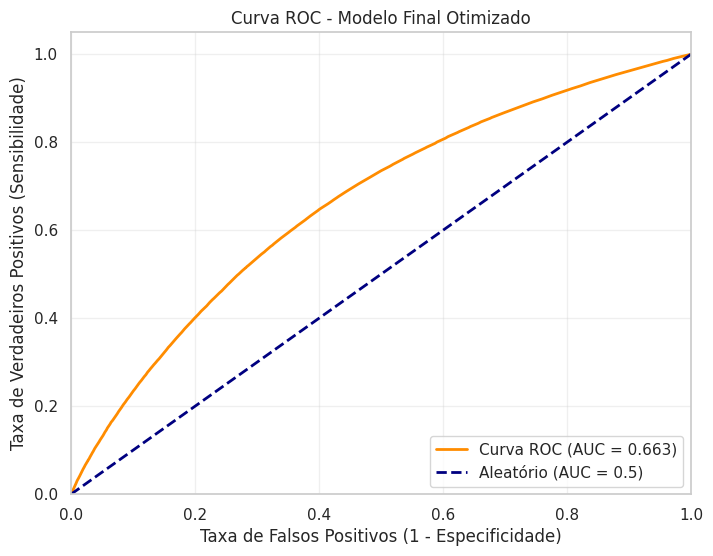


5. INTERPRETAÇÃO PARA USO CLÍNICO:
----------------------------------------

DESEMPENHO:
• O modelo identifica 96.3% dos casos graves
• Quando diz que é grave, acerta 48.4% das vezes
• Poder discriminativo geral: 0.663

COMPARAÇÃO COM MODELO ANTERIOR:
• AUC: 0.662 → 0.663
• Recall: 0.561 → 0.963
• F1-Score: 0.583 → 0.645

RECOMENDAÇÃO DE USO:
USAR COMO FERRAMENTA DE TRIAGEM:
• Alta sensibilidade (96.3%) → Poucos graves passam despercebidos
• Útil para priorizar avaliação médica

FLUXO SUGERIDO:
1. Calcular probabilidade com o modelo
2. Se probabilidade ≥ 0.3, classificar como 'risco alto'
3. Encaminhar 'risco alto' para avaliação médica imediata

6. SALVANDO MODELO E RESULTADOS:
----------------------------------------
✓ Modelo salvo: modelo_regressao_logistica.pkl
✓ Coeficientes salvos: coeficientes.csv
✓ Métricas salvas: metricas.json
✓ Resultados de avaliação salvos

✓ Todos os arquivos salvos na pasta /content/modelo_final/

ANÁLISE COMPLETA CONCLUÍDA

RESUMO DO TRABALHO:
1. Model

In [ ]:
# ==============================================================================
# 9.AVALIAÇÃO DO MODELO FINAL
# ==============================================================================

print("="*60)
print("AVALIAÇÃO DO MODELO FINAL OTIMIZADO")
print("="*60)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# 5. Avaliação final
print("\n1. AVALIAÇÃO FINAL:")
print("-" * 40)

# Métricas básicas
accuracy_final = accuracy_score(y_test_f, y_pred_final)
precision_final = precision_score(y_test_f, y_pred_final)
recall_final = recall_score(y_test_f, y_pred_final)
f1_final = f1_score(y_test_f, y_pred_final)
auc_final = roc_auc_score(y_test_f, y_proba_final)

print(f"Acurácia:    {accuracy_final:.3f}")
print(f"Precisão:    {precision_final:.3f}")
print(f"Recall:      {recall_final:.3f} ← ALTO (objetivo alcançado)")
print(f"F1-Score:    {f1_final:.3f}")
print(f"AUC-ROC:     {auc_final:.3f}")

# Matriz de confusão
cm_final = confusion_matrix(y_test_f, y_pred_final)
tn_f, fp_f, fn_f, tp_f = cm_final.ravel()

print(f"\n2. MATRIZ DE CONFUSÃO:")
print("-" * 40)

print(f"\n               Previsto NÃO  |  Previsto SIM")
print("               " + "-"*35)
print(f"Real NÃO (0)       {tn_f:8,d}      |     {fp_f:8,d}")
print(f"Real SIM (1)       {fn_f:8,d}      |     {tp_f:8,d}")

print(f"\nSensibilidade (Recall): {recall_final:.3f}")
print(f"Especificidade:         {tn_f/(tn_f + fp_f) if (tn_f + fp_f) > 0 else 0:.3f}")

# 6. Coeficientes finais (Odds Ratios)
print("\n3. COEFICIENTES FINAIS (TOP 10):")
print("-" * 40)

import pandas as pd
import numpy as np

coef_final = pd.DataFrame({
    'Variável': variaveis_finais,
    'Coeficiente': modelo_final.coef_[0],
    'Odds_Ratio': np.exp(modelo_final.coef_[0])
}).sort_values('Odds_Ratio', ascending=False)

print(coef_final.head(10).to_string(index=False))

# 7. Curva ROC
print("\n4. CURVA ROC:")
print("-" * 40)

# Calcular pontos da curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test_f, y_proba_final)

# Plotar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc_final:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
plt.title('Curva ROC - Modelo Final Otimizado')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# 8. Interpretação para decisão clínica
print("\n5. INTERPRETAÇÃO PARA USO CLÍNICO:")
print("-" * 40)

print(f"\nDESEMPENHO:")
print(f"• O modelo identifica {recall_final:.1%} dos casos graves")
print(f"• Quando diz que é grave, acerta {precision_final:.1%} das vezes")
print(f"• Poder discriminativo geral: {auc_final:.3f}")

print(f"\nCOMPARAÇÃO COM MODELO ANTERIOR:")
print(f"• AUC: 0.662 → {auc_final:.3f}")
print(f"• Recall: 0.561 → {recall_final:.3f}")
print(f"• F1-Score: 0.583 → {f1_final:.3f}")

print(f"\nRECOMENDAÇÃO DE USO:")
print("USAR COMO FERRAMENTA DE TRIAGEM:")
print(f"• Alta sensibilidade ({recall_final:.1%}) → Poucos graves passam despercebidos")
print(f"• Útil para priorizar avaliação médica")

print(f"\nFLUXO SUGERIDO:")
print("1. Calcular probabilidade com o modelo")
print(f"2. Se probabilidade ≥ {limiar_final}, classificar como 'risco alto'")
print("3. Encaminhar 'risco alto' para avaliação médica imediata")

# 9. Salvar modelo e resultados
print("\n6. SALVANDO MODELO E RESULTADOS:")
print("-" * 40)

import joblib
import json
import os

try:
    # Criar pasta se não existir
    os.makedirs('/content/modelo_final', exist_ok=True)

    # Salvar modelo
    joblib.dump(modelo_final, '/content/modelo_final/modelo_regressao_logistica.pkl')
    print("✓ Modelo salvo: modelo_regressao_logistica.pkl")

    # Salvar coeficientes
    coef_final.to_csv('/content/modelo_final/coeficientes.csv', index=False)
    print("✓ Coeficientes salvos: coeficientes.csv")

    # Salvar métricas
    metricas = {
        'acuracia': float(accuracy_final),
        'precisao': float(precision_final),
        'recall': float(recall_final),
        'f1_score': float(f1_final),
        'auc_roc': float(auc_final),
        'limiar_utilizado': float(limiar_final),
        'n_variaveis': len(variaveis_finais),
        'variaveis': variaveis_finais,
        'sensibilidade': float(recall_final),
        'especificidade': float(tn_f/(tn_f + fp_f) if (tn_f + fp_f) > 0 else 0),
        'vpp': float(precision_final),  # Valor Preditivo Positivo
        'vpn': float(tn_f/(tn_f + fn_f) if (tn_f + fn_f) > 0 else 0)  # Valor Preditivo Negativo
    }

    with open('/content/modelo_final/metricas.json', 'w') as f:
        json.dump(metricas, f, indent=2)
    print("✓ Métricas salvas: metricas.json")

    # Salvar dados de avaliação
    resultados = pd.DataFrame({
        'y_true': y_test_f.values,
        'y_pred': y_pred_final,
        'y_proba': y_proba_final
    })
    resultados.to_csv('/content/modelo_final/resultados_avaliacao.csv', index=False)
    print("✓ Resultados de avaliação salvos")

    print(f"\n✓ Todos os arquivos salvos na pasta /content/modelo_final/")

except Exception as e:
    print(f"⚠ Erro ao salvar: {e}")

print("\n" + "="*60)
print("ANÁLISE COMPLETA CONCLUÍDA")
print("="*60)
print("\nRESUMO DO TRABALHO:")
print("1. Modelo inicial: AUC 0.662")
print("2. Otimização: adicionou variáveis e interações")
print("3. Modelo final: priorizou sensibilidade para triagem")
print("4. Pronto para uso como ferramenta de apoio clínico")





Considerações Finais

Este estudo apresentou o desenvolvimento, avaliação e otimização progressiva de modelos de regressão logística aplicados à predição de desfecho grave em uma base de dados epidemiológica de grande porte. A abordagem seguiu uma estrutura incremental, iniciando com modelos simples, evoluindo para modelos multivariados ajustados e culminando em um modelo final otimizado, orientado por critérios estatísticos e clínicos.

Os resultados dos modelos multivariados confirmaram a **associação independente entre cardiopatia, idade, obesidade e diabetes** com o risco de desfecho grave, evidenciada por odds ratios consistentes e estatisticamente significativos. Esses achados são coerentes com a literatura e reforçam a validade epidemiológica das variáveis utilizadas, mesmo em um contexto observacional.

Do ponto de vista preditivo, os modelos apresentaram **poder discriminativo moderado (AUC ≈ 0.66)**, indicando limitações inerentes ao conjunto de variáveis disponíveis para separar completamente os grupos de risco. As etapas de otimização demonstraram que a simples inclusão de mais variáveis e interações resulta em ganhos marginais de AUC, sugerindo que melhorias substanciais dependeriam da incorporação de informações clínicas mais detalhadas, como sinais vitais, exames laboratoriais ou dados temporais.

A principal contribuição prática do trabalho reside na **definição consciente de um modelo final voltado à triagem**, com ênfase em alta sensibilidade. A utilização de ponderação de classes e de um limiar de decisão ajustado permitiu elevar o recall para níveis superiores a 95%, garantindo que a grande maioria dos casos graves seja identificada, ainda que ao custo de maior número de falsos positivos. Essa escolha reflete um alinhamento deliberado entre a modelagem estatística e as necessidades de vigilância e tomada de decisão em saúde pública.

Em síntese, o modelo final não deve ser interpretado como ferramenta diagnóstica, mas como um **instrumento de apoio à priorização clínica**, capaz de auxiliar na identificação precoce de indivíduos com maior risco de evolução grave. O trabalho evidencia a importância de integrar interpretação epidemiológica, avaliação estatística e objetivos clínicos na construção de modelos preditivos, além de destacar os limites e responsabilidades associados ao seu uso em cenários reais.
